# Run grid of single stars

- grid file should include Metallicity, Period, Masses in range 10-150
- in logfile add if wich star is going SN
- Run simulation
- extract table that includes M_ZAMS, M_core-SN, M_env-SN,


In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import h5py as h5
from matplotlib.colors import ListedColormap
from astropy.table import Table

from subprocess import Popen, PIPE
import subprocess

import traceback

from astropy import constants as const
from astropy import units as u

from definitions import sim_flags_dict

import importlib
# Reload the definitions module
importlib.reload(sys.modules['definitions'])
from definitions import sim_flags_dict

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,18,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



In [2]:
#################################################################
##   Parameters to set
#################################################################
home_dir        = os.path.expanduser("~")
proj_dir        = home_dir +'/Winds2/' #+ '/Documents/Projects/'

sim_name        = "NewWinds_RemFryer2012_oldRSG"#"OldWinds_RemFryer2012" # sim_name determines which flags to run COMPAS with
compas_v        = "v03.01.02" #"v02.46.01/"#v02.35.02/"
root_out_dir    =  f"{home_dir}/ceph/CompasOutput/{compas_v}/{sim_name}"


Z_array         = np.logspace(-4,np.log10(0.03), num=100) 
sma             = 10000.
write_gird      = True # write the grid files?
run_grid        = True # run the grid files?



In [3]:
# Check if sim_name exists in the dictionary
if sim_name in sim_flags_dict:
    sim_variation_flags = sim_flags_dict[sim_name]
    print(sim_variation_flags)
else:
    print(f"Unknown sim_name: {sim_name}")


--OB-mass-loss-prescription VINK2021 --VMS-mass-loss-prescription SABHAHIT2023 --RSG-mass-loss-prescription NJ90  --WR-mass-loss-prescription SANDERVINK2023  --remnant-mass-prescription FRYER2012 --kick-magnitude-distribution MAXWELLIAN 


In [4]:
#################################################################
##   Write a grid of Single stars to root_out_dir
#################################################################

# Make a folder to store the Single star grids if it doesn't exist yet
if not os.path.exists(root_out_dir + '/SingleStarGrids'):
    os.makedirs(root_out_dir + '/SingleStarGrids')
    
# Copy the output definitions
os.system(f'cp /{proj_dir}/code/GridSubmitCOMPAS/masterfolder/MainRun/COMPAS_Output_Definitions.txt {root_out_dir}/SingleStarGrids/')

for M in [10,20,30,40,50,60,70,80,90,100,150]:    
    grid_file_name = f'Single_star_M{M}_metallicities.txt'

    #################################################################
    # Write the grid
    if write_gird:
        print('writing grid for mass', M)

        # Open the output file for writing
        with open(root_out_dir + '/SingleStarGrids/' + grid_file_name, 'w') as f:
            # Write a grid file of len mass_array
            for i in range(len(Z_array)):
                # write the line
                f.write(f'--random-seed {i} --initial-mass-1 {M} --initial-mass-2 {M} --metallicity {Z_array[i]} --semi-major-axis {sma} \n ' )
    

writing grid for mass 10
writing grid for mass 20
writing grid for mass 30
writing grid for mass 40
writing grid for mass 50
writing grid for mass 60
writing grid for mass 70
writing grid for mass 80
writing grid for mass 90
writing grid for mass 100
writing grid for mass 150


In [5]:
#################################################################
##   Run the grid of Single stars with COMPAS
#################################################################
if run_grid:

    # open a file to write the tasks to 
    with open(f'{root_out_dir}/SingleStarGrids/SingleStarTasks', 'w') as f:

        for M in [10,20,30,40,50,60,70,80,90,100,150]:
            print('running mass', M)
            
            # Compile flags to use
            grid_file_name = f'Single_star_M{M}_metallicities.txt'
            container_name = f'SingleStars_M{M}'

            general_flags = f" --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --output-container '{container_name}' --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "

            COMPAS_batch_flags = general_flags + sim_variation_flags

            task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {COMPAS_batch_flags}  > SingleStars{M}.log 2>&1 " 
            f.write(task_line + '\n')
        
    # Run all tasks with DisBatch disBatch Command
    command = f"module load disBatch && sbatch -p gen -n 20 disBatch {root_out_dir}/SingleStarGrids/SingleStarTasks"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

else:
    print(f'run_grid = {run_grid}')



running mass 10
running mass 20
running mass 30
running mass 40
running mass 50
running mass 60
running mass 70
running mass 80
running mass 90
running mass 100
running mass 150


# Load the data you've just created

In [6]:
# Mapping types to names 
Stellar_Type_table = Table()
Stellar_Type_table['types'] = ['MS_low', 'MS' ,'HG', 'AGB', 'CHeB', 'EAGB','TPAGB','HeMS','HeHG','HeGB','HeWD','COWD','ONeWD','NS','BH','massless remnant']
Stellar_Type_table['indices'] = np.arange(len(Stellar_Type_table))

# NEW mass loss types
Wind_prescr_table = Table()
# Wind_prescr_table['types'] = ['NONE', 'OB', 'VMS', 'GB', 'RSG', 'WR', 'LBV']
Wind_prescr_table['types'] = ['NONE', 'GB', 'LBV', 'OB', 'RSG', 'VMS', 'WR']
Wind_prescr_table['indices'] = np.arange(len(Wind_prescr_table))

# from typedefs.h line 592:
# // symbolic names for mass loss rate type
# enum class MASS_LOSS_TYPE: int { NONE, GB, LBV, OB, RSG, VMS, WR};
# const COMPASUnorderedMap<MASS_LOSS_TYPE, std::string> MASS_LOSS_TYPE_LABEL = {
#     { MASS_LOSS_TYPE::NONE, "NONE" },
#     { MASS_LOSS_TYPE::GB,   "GB" },
#     { MASS_LOSS_TYPE::LBV,  "LBV" },
#     { MASS_LOSS_TYPE::OB,   "OB" },
#     { MASS_LOSS_TYPE::RSG,  "RSG" },
#     { MASS_LOSS_TYPE::VMS,  "VMS" },
#     { MASS_LOSS_TYPE::WR,   "WR" }
# };

# # Old mass loss types
# Wind_prescr_table = Table()
# Wind_prescr_table['types'] = ['None', 'Nieuwenhuijzen and de Jager', 'Kudritzki and Reimers', 'Vassiliadis and Wood', 'Wolf-Rayet-like (Hamann, Koesterke and de Koter)', 'Vink', 'Luminous Blue Variable']
# Wind_prescr_table['indices'] = np.arange(len(Wind_prescr_table))


def get_max_radii(loc = '{root_out_dir}/SingleStarGrids/SingleStars_M10/'):
    Metals, maxRadii, maxR_type, maxR_massloss    = [],  [],  [],  []

    for i in range(100):
        # Read detailed hdf5 file
        detailed_data = f'{loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5'
        detailh5 = h5.File(detailed_data, 'r')

        # Get the relevant info out
        i_maxR = np.argmax(detailh5['Radius(1)'][()])
        Metals.append(detailh5['Metallicity@ZAMS(1)'][0])
        maxRadii.append( detailh5['Radius(1)'][i_maxR] )
        maxR_type.append(detailh5['Stellar_Type(1)'][i_maxR])   
        maxR_massloss.append(detailh5['Dominant_Mass_Loss_Rate(1)'][i_maxR])

        maxR_RL1 = np.max(detailh5['Radius(1)'][()]/detailh5['RocheLobe(1)'][()]) 
        if maxR_RL1 > 1.0:
            print(f'Watch out!RL1: {maxR_RL1} for {i}')
        maxR_RL2 = np.max(detailh5['Radius(2)'][()]/detailh5['RocheLobe(2)'][()]) 
        if maxR_RL2 > 1.0:
            print(f'Watch out! RL2: {maxR_RL2} for {i}')
    return Metals, maxRadii, maxR_type, maxR_massloss

In [8]:
# Initialize an empty dictionary
data = {
    'M0': [],
    'Metals': [],
    'maxRadii': [],
    'maxR_type': [],
    'maxR_massloss': [],
    #
    'R_ZAMS': [],
    'maxR_MS': [],
    'maxR_HG': [],
    'maxR_FGB': [],
    'maxR_CHeB': [],
    'maxR_EAGB': [],
    #
    'Luminosity': [],
    'Teff': [],
    'Radius': [],
    'Mass': [],
    'Age': [],
    'Stellar_Type': [],
    'Dominant_Wind': []
}

# For each mass, compute the values and append them to the lists
for mass in [10, 20, 30, 40, 50, 60, 70,90, 100, 150]:
    print('mass', mass)

    read_loc =  f'{root_out_dir}/SingleStarGrids/SingleStars_M{mass}/'

    print('reading ', read_loc)
    
    try:
        Metals, maxRadii, maxR_type, maxR_massloss   = [],  [],  [],  []
        R_ZAMS, maxR_MS, maxR_HG, maxR_FGB, maxR_CHeB, maxR_EAGB = [], [], [], [], [], []
        L, Teff, M, age, Radius, stellar_type, dominant_wind = [], [], [], [], [], [], []

        for i in range(100):
            # Read detailed hdf5 file
            detailh5 = h5.File(f'{read_loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5', 'r')

            ####################################### 
            # Maximum radius at all times
            i_maxR = np.argmax(detailh5['Radius(1)'][()])
            Metals.append(detailh5['Metallicity@ZAMS(1)'][0])
            maxRadii.append( detailh5['Radius(1)'][i_maxR] )
            maxR_type.append(detailh5['Stellar_Type(1)'][i_maxR])   
            maxR_massloss.append(detailh5['Dominant_Mass_Loss_Rate(1)'][i_maxR])

            #######################################
            # Select the maximum radius for each stellar type
            R_ZAMS.append(detailh5['Radius(1)'][0])

            st1 = detailh5['Stellar_Type(1)'][()]
            MS_bool = np.logical_or(st1 == 0, st1 == 1)
            maxR_MS.append(max(detailh5['Radius(1)'][MS_bool]) )

            HG_bool = st1 == 2
            maxR_HG.append(max(detailh5['Radius(1)'][HG_bool]) if np.any(HG_bool) > 0 else 0)

            FGB_bool = st1 == 3
            maxR_FGB.append(max(detailh5['Radius(1)'][FGB_bool]) if np.any(FGB_bool) > 0 else 0)
            
            CHeB_bool = st1 == 4
            maxR_CHeB.append(max(detailh5['Radius(1)'][CHeB_bool]) if np.any(CHeB_bool) > 0 else 0 )

            EAGB_bool = st1 == 5
            maxR_EAGB.append(max(detailh5['Radius(1)'][EAGB_bool]) if np.any(EAGB_bool) > 0 else 0 )

            #######################################
            # For HR diagram
            L.append(detailh5['Luminosity(1)'])
            Teff.append(detailh5['Teff(1)'])
            Radius.append(detailh5['Radius(1)'])
            M.append(detailh5['Mass(1)'])
            age.append(detailh5['Age(1)'])
            
            stellar_type.append(detailh5['Stellar_Type(1)'])
            dominant_wind.append(detailh5['Dominant_Mass_Loss_Rate(1)'])

            maxR_RL1 = np.max(detailh5['Radius(1)'][()]/detailh5['RocheLobe(1)'][()]) 
            if maxR_RL1 > 1.0:
                print(f'Watch out! maxR_RL1: {maxR_RL1} for {i}')
            maxR_RL2 = np.max(detailh5['Radius(2)'][()]/detailh5['RocheLobe(2)'][()]) 
            if maxR_RL2 > 1.0:
                print(f'Watch out! maxR_RL2: {maxR_RL2} for {i}')
                    
        # Max R
        data['M0'].append(mass)
        data['Metals'].append(Metals)
        data['maxRadii'].append(maxRadii)
        data['maxR_type'].append(maxR_type)
        data['maxR_massloss'].append(maxR_massloss)

        # Max R per type
        data['R_ZAMS'].append(R_ZAMS)
        data['maxR_MS'].append(maxR_MS)
        data['maxR_HG'].append(maxR_HG)
        data['maxR_FGB'].append(maxR_FGB)
        data['maxR_CHeB'].append(maxR_CHeB)
        data['maxR_EAGB'].append(maxR_EAGB)

        # HR
        data['Luminosity'].append(L)
        data['Teff'].append(Teff)   
        data['Radius'].append(Radius)  
        data['Mass'].append(M)  
        data['Age'].append(age)  
        data['Stellar_Type'].append(stellar_type)  
        data['Dominant_Wind'].append(dominant_wind)  

    except Exception as e:
        print('ERR:', e)
        traceback.print_exc()
        continue


print(data['M0'])

mass 10
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M10/
mass 20
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M20/
mass 30
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M30/
mass 40
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M40/
mass 50
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M50/
mass 60
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M60/
mass 70
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M70/
mass 90
reading  /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012_oldRSG/SingleStarGrids/SingleStars_M90/


In [9]:
# read_loc = loc + f'/SingleStarGrids/SingleStars_M{100}'
# detailed_data = read_loc + f'/Detailed_Output/BSE_Detailed_Output_{80}.h5'
# detailh5 = h5.File(detailed_data, 'r')

print(data['maxR_HG'])
print(data['Dominant_Wind'][0][1][:]) #[mi][zi]


[[26.68042471640144, 27.85262068848405, 29.0241768918391, 30.208633154830487, 31.418918575251368, 32.66756725485634, 33.96604261327395, 35.32589163787087, 33.40092320739832, 38.273227614963616, 39.88256026558866, 41.595470566831985, 43.65034267553825, 46.32899331199848, 44.169258668618106, 46.9867405964279, 56.31746077013953, 60.447765243867416, 65.06582644061349, 70.23500735773038, 76.02412287306505, 82.5065037262686, 89.76417454823263, 97.88973527025878, 106.97894508340113, 117.13568403422552, 128.47275267355516, 141.100306722507, 155.1359134553368, 170.70725843151462, 187.931645785695, 206.92673470341668, 188.80638444836563, 250.66938714792028, 226.186873850237, 302.7227353456048, 256.46176509376795, 206.83716079849452, 239.25236940201577, 230.0283170017276, 222.06081522823172, 203.4223888240456, 219.76000505146004, 282.72007515858087, 249.67867465728503, 262.6963966146294, 331.2034386202911, 343.16633573766717, 352.68840267421893, 297.0909888204171, 364.03898019331035, 365.86311281

In [10]:
data.keys()

dict_keys(['M0', 'Metals', 'maxRadii', 'maxR_type', 'maxR_massloss', 'R_ZAMS', 'maxR_MS', 'maxR_HG', 'maxR_FGB', 'maxR_CHeB', 'maxR_EAGB', 'Luminosity', 'Teff', 'Radius', 'Mass', 'Age', 'Stellar_Type', 'Dominant_Wind'])

[40.         40.         40.         ...  7.81269915  7.81269915
  7.81269915]
dict_keys(['M0', 'Metals', 'maxRadii', 'maxR_type', 'maxR_massloss', 'R_ZAMS', 'maxR_MS', 'maxR_HG', 'maxR_FGB', 'maxR_CHeB', 'maxR_EAGB', 'Luminosity', 'Teff', 'Radius', 'Mass', 'Age', 'Stellar_Type', 'Dominant_Wind'])
-1.0201638289874821
[0 2 3 6]


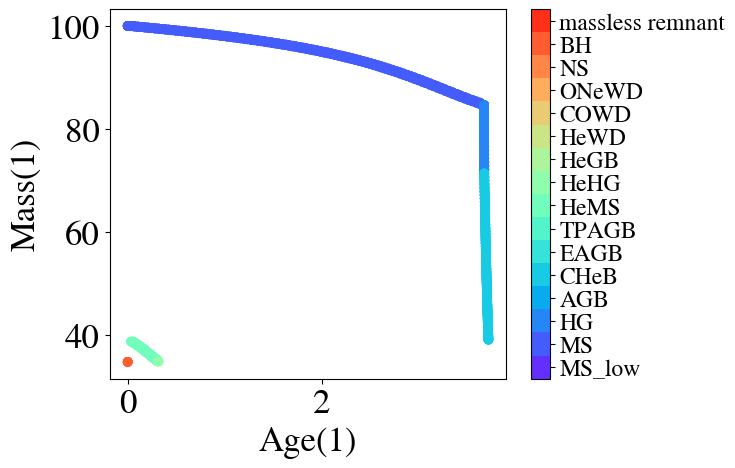

In [11]:
# [key][mi][zi][]
print(data['Mass'][3][99][:]) # 10, 20, 30, 40, 50, 60, 70, 90, 100, 150
print(data.keys())
print(np.log10(data['Metals'][0][45]/0.014 ) ) # 0-99

# star w. zams mass 70 and log(Z/Zsun) = -1
dom_wind_70Msun = data['Dominant_Wind'][6][45][:]
Mass_70Msun = data['Mass'][6][45][:]
dm = np.diff(data['Mass'][6][45][:])
# plt.scatter(np.linspace(0, 1, len(dm)), dm, c =data['Dominant_Wind'][6][45][1:] , cmap = 'rainbow') 

print(np.unique(dom_wind_70Msun) )

newcmp = ListedColormap(sns.color_palette("rainbow", len(Stellar_Type_table))) 

im = plt.scatter(data['Age'][8][45][:], data['Mass'][8][45][:], c =  data['Stellar_Type'][8][45][:], 
            vmin = min(Stellar_Type_table['indices']) -0.5, vmax= max(Stellar_Type_table['indices']) + 0.5,
            cmap = newcmp)
plt.xlabel('Age(1)')
plt.ylabel('Mass(1)')
                     
# Create the colorbar
cb = plt.colorbar(im, ticks=Stellar_Type_table['indices'])
cb.ax.set_yticklabels(Stellar_Type_table['types'], size = 17)

# plt.xticks(np.arange(0, 16), Stellar_Type_table['types'], rotation = 45)
# plt.ylim(0,50)

# plt.colorbar()
# plt.ylabel('dM')
plt.show()

# Plot the maximum radius for every type at every metallicity

10


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")


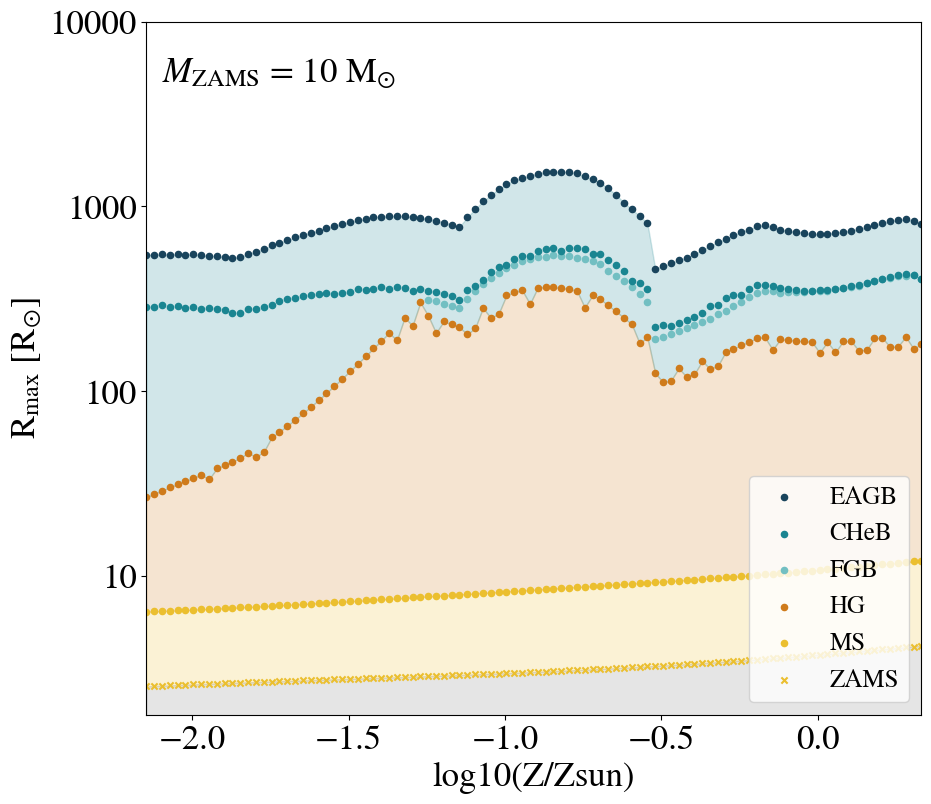

20


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")


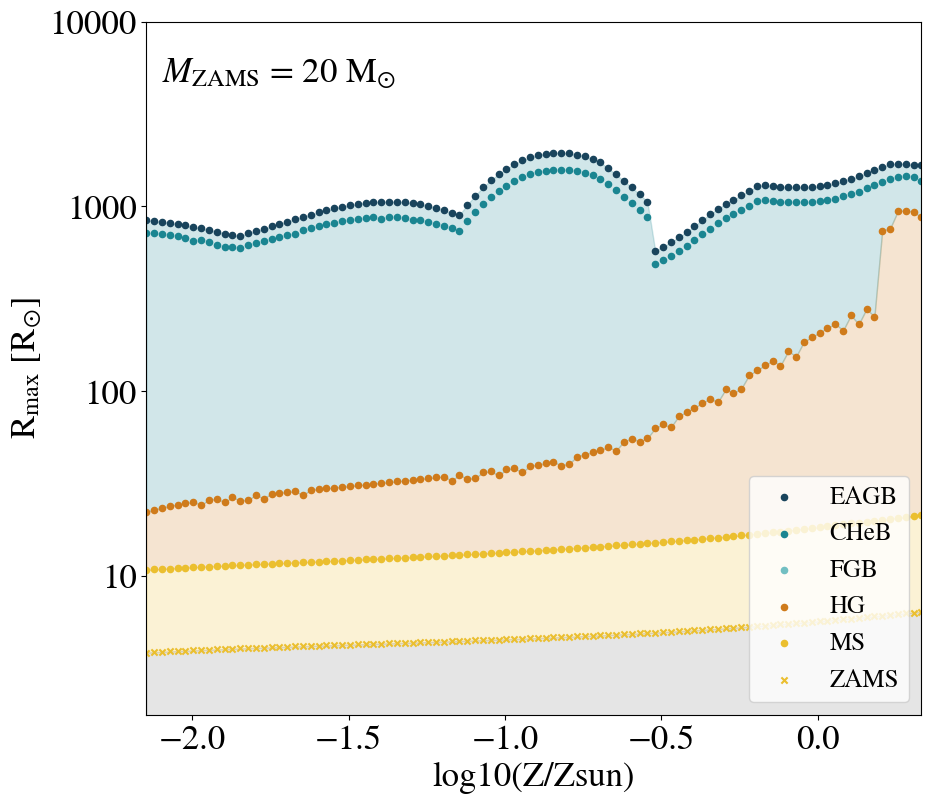

30


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


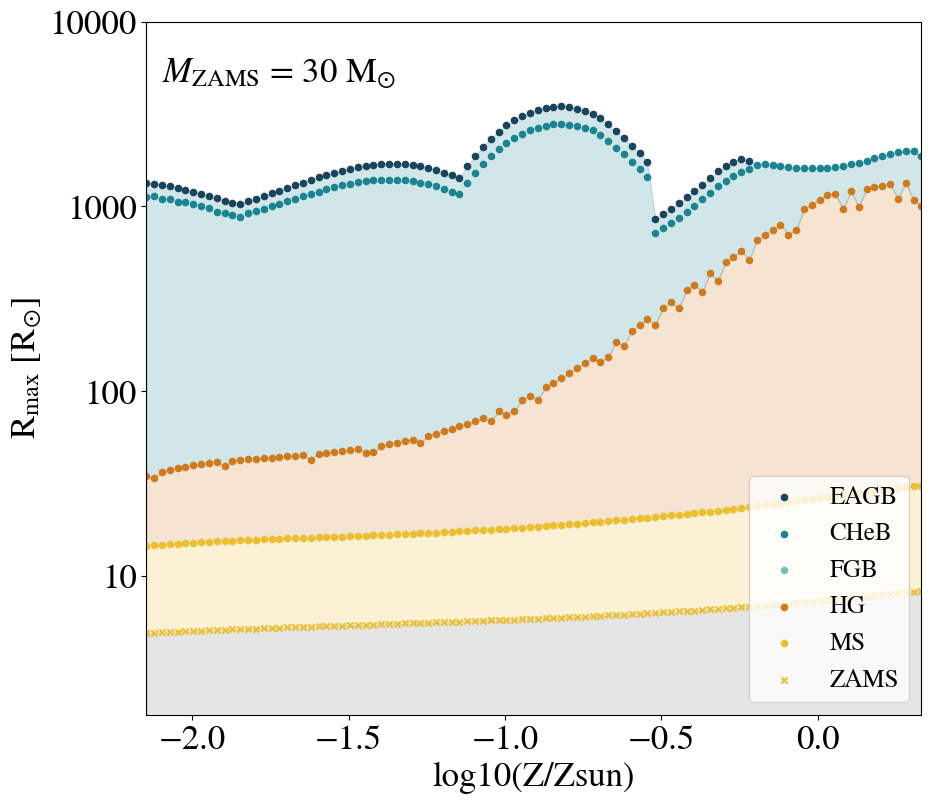

40


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


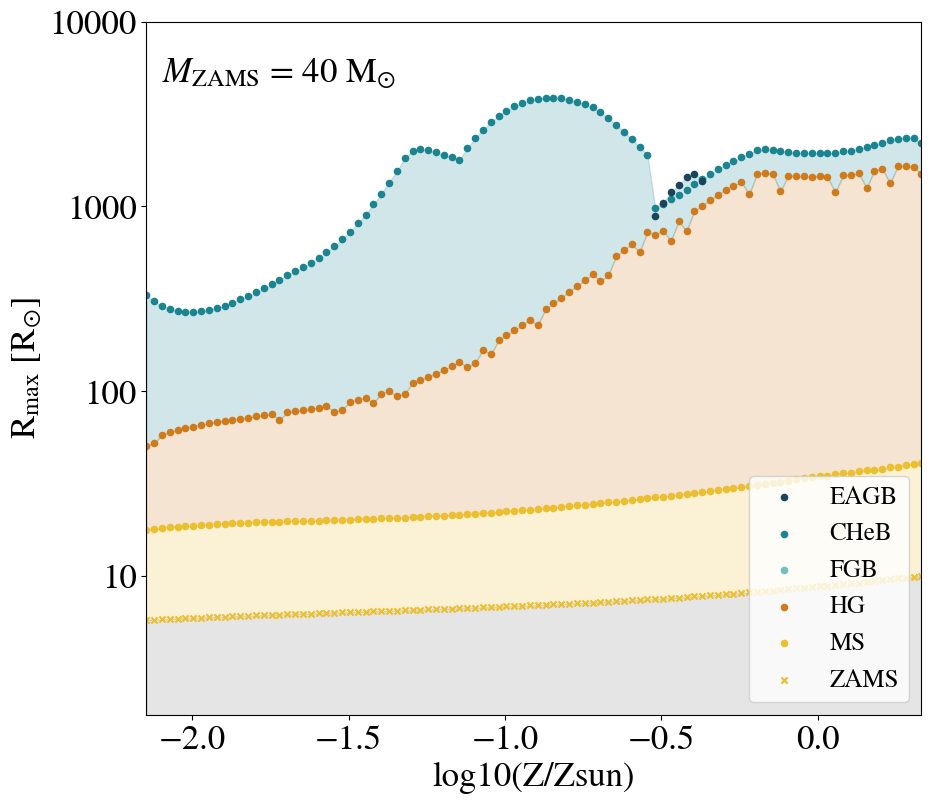

50


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


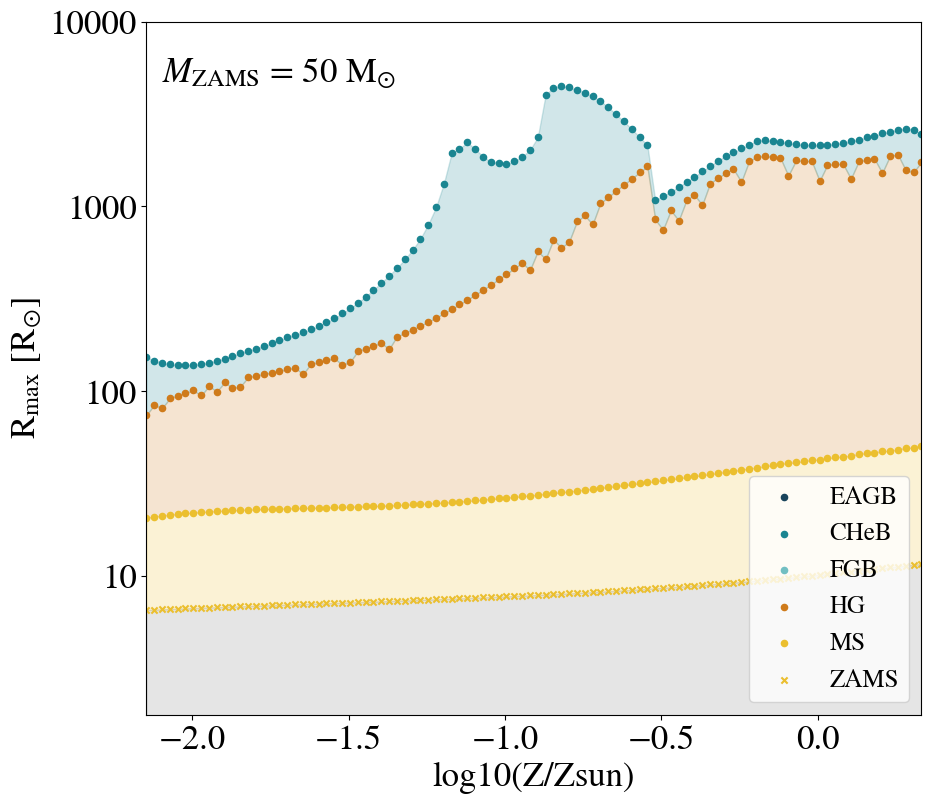

60


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


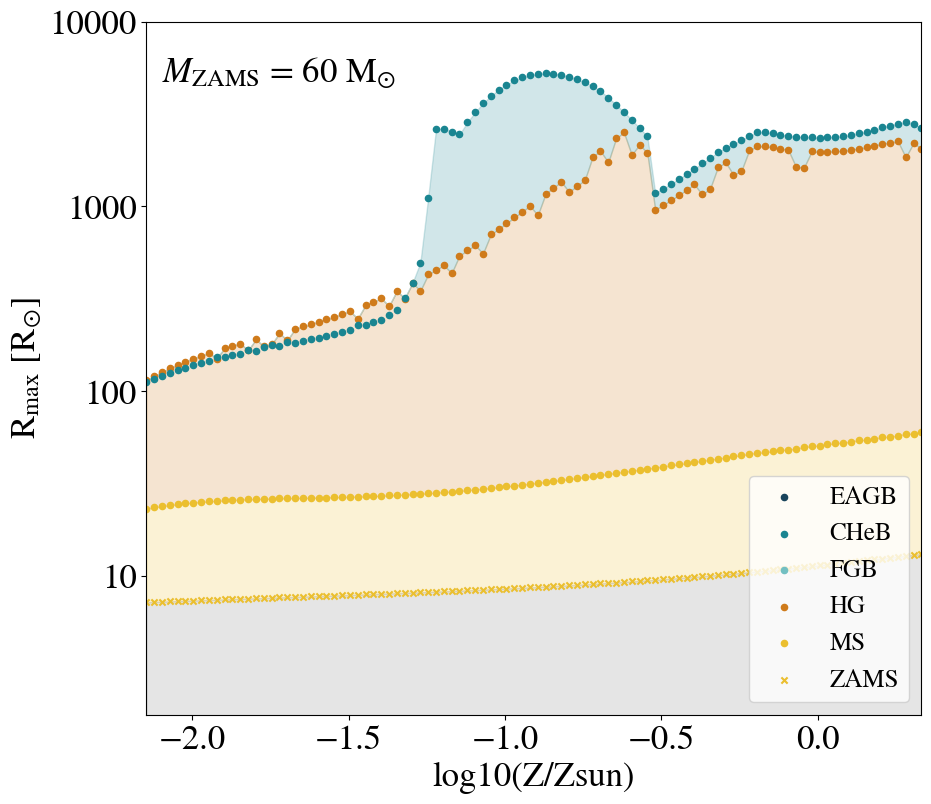

70


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


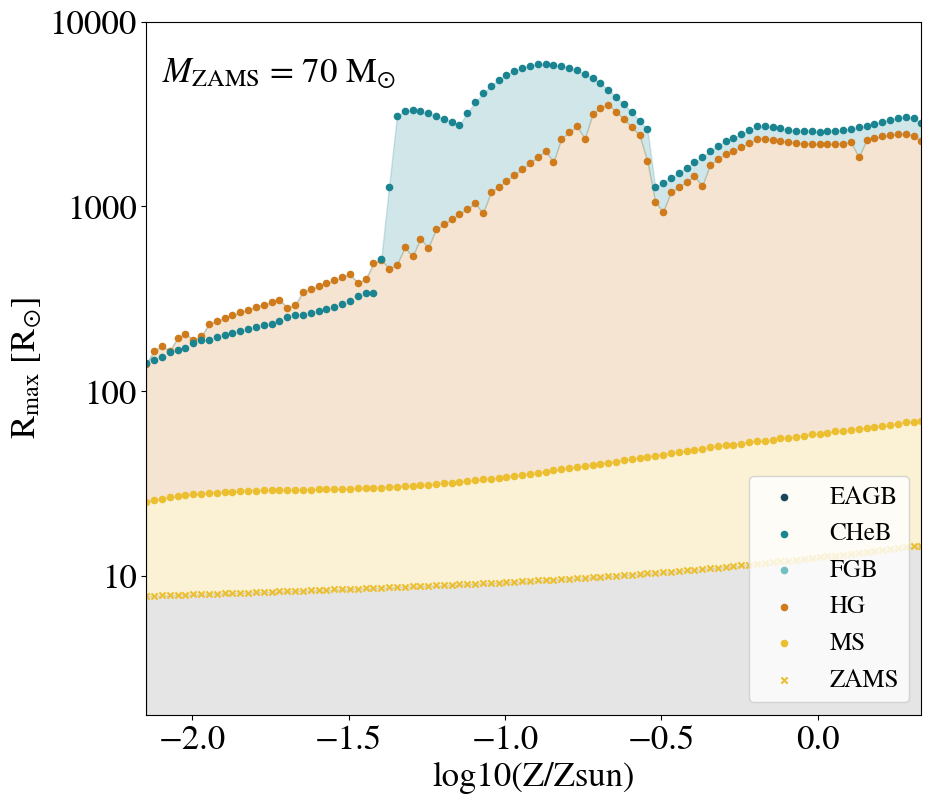

90


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


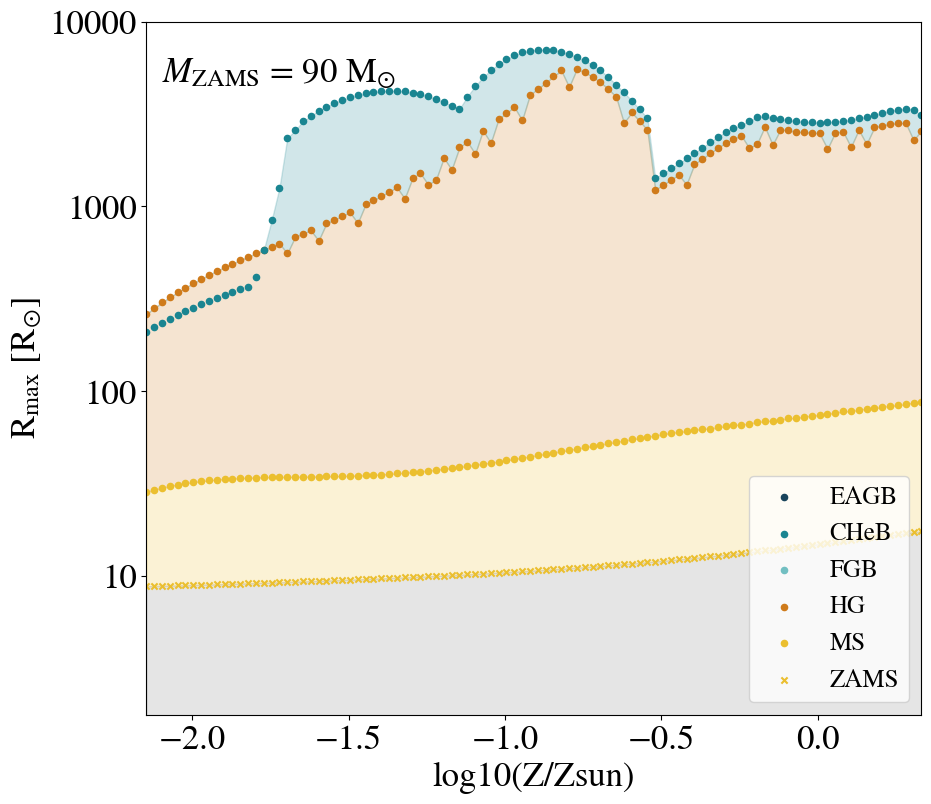

100


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


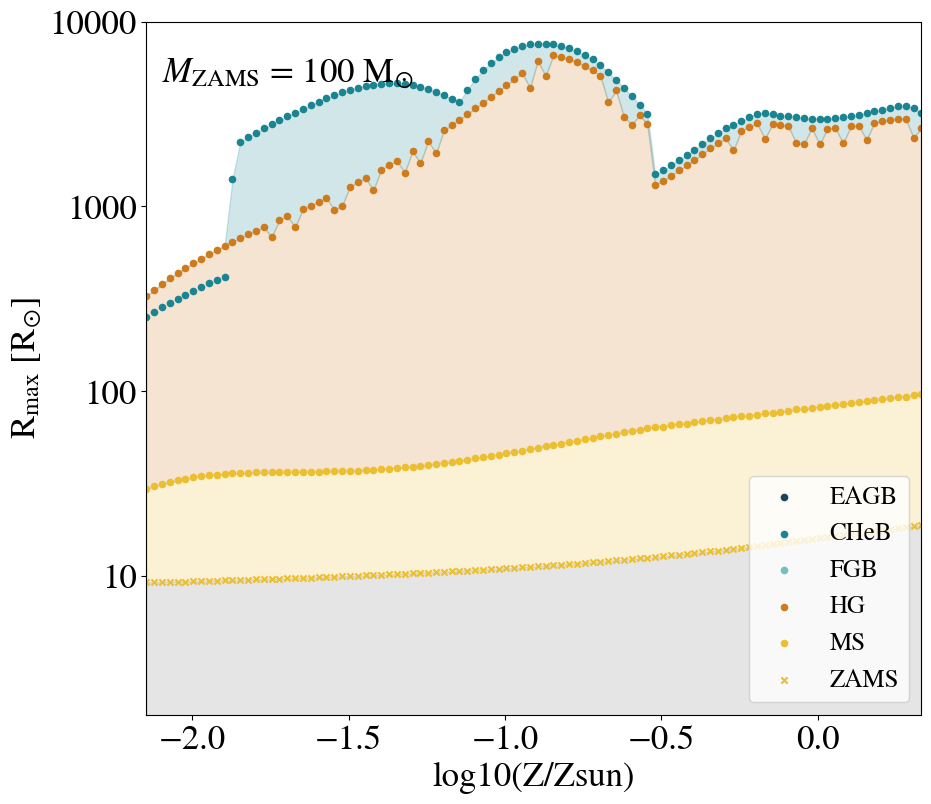

150


/tmp/ipykernel_4036742/676665727.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_4036742/676665727.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


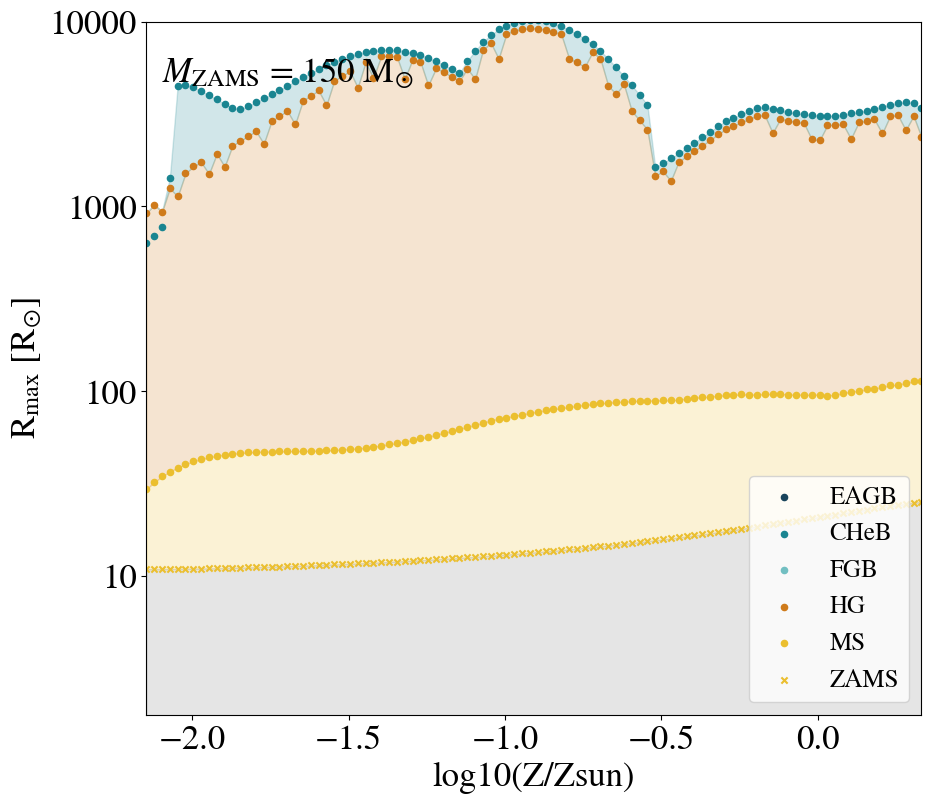

In [12]:
colors =  sns.color_palette("Paired", 6) # color for masses
linestyles = ['-'] #['-', '--', '-.', ':']
marker_dict = {4: 'o', 5: 'x'}  # to indicate the type


# Select only one mass
for mi, mass in enumerate(data['M0']):
        print(mass)

        fig, ax = plt.subplots(figsize =(10,9))

        plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 =0, y2 = np.log10(data['R_ZAMS'][mi]),  color = 'grey', alpha = 0.2)

        # R_ZAMS
        plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['R_ZAMS'][mi]), c = '#ebbf2f', s = 20, marker = 'x', label = 'ZAMS')

        # Case A is up to max MS
        plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['R_ZAMS'][mi]), y2 = np.log10(data['maxR_MS'][mi]),  color = '#ebbf2f', alpha = 0.2)

        #Case B is between MS and HG 
        plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['maxR_MS'][mi]), y2 = np.log10(data['maxR_HG'][mi]),  color = '#cf7b1b', alpha = 0.2)

        # Case C is beyond HG
        plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['maxR_HG'][mi]), y2 = np.log10(data['maxRadii'][mi]),  color = '#1a8591', alpha = 0.2)

        # Per types
        plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_MS'][mi]), c = '#ebbf2f', s = 20, label = 'MS')

        plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_HG'][mi]), c = "#cf7b1b", s = 20, label = "HG")

        plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
        # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", lw = 2, label = None)

        plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_CHeB'][mi]), c = "#1a8591", s = 20, label = "CHeB")
        # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_CHeB'][mi]), c = "#1a8591", lw = 2, label = None)

        plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")
        # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", lw = 4, label = None)



        ax.text(0.02, 0.9, r'$M_{\rm ZAMS}$ = %s M$_{\odot}$'%(mass), transform=ax.transAxes, 
                ha = 'left', va = 'bottom', size = 25)

        # Plotvalues
        handles, labels = ax.get_legend_handles_labels() # Reverse legend order
        ax.legend(handles[::-1], labels[::-1], loc = 'lower right')
        plt.xlabel('log10(Z/Zsun)')
        plt.yticks([0, 1, 2, 3, 4., 5], ['1','10','100', '1000', '10000', '100000'])
        plt.xlim(np.log10(1e-4/0.014), np.log10(0.03/0.014))
        plt.ylim(0.25, 4)
        plt.ylabel('R$_{\mathrm{max} }$ [R$_{\odot}$]')
        # plt.savefig(proj_dir + f'/plots/MaxR_Type_perZ_M{mass}_{var_name}_{version}.pdf',bbox_inches='tight')

        # Make a plot dir in the data dir if it doesnt exist yet
        if not os.path.exists(f'{root_out_dir}/plots/'):
            os.makedirs(f'{root_out_dir}/plots/')
        plt.savefig(f'{root_out_dir}/plots/MaxR_Type_perZ_M{mass}.pdf',bbox_inches='tight')

        plt.show()


# Plot the maximum radius as a function of metallicity for every system

unique_type_values [2 4 5]
10
20
30
40
50
60
70
90
100
150


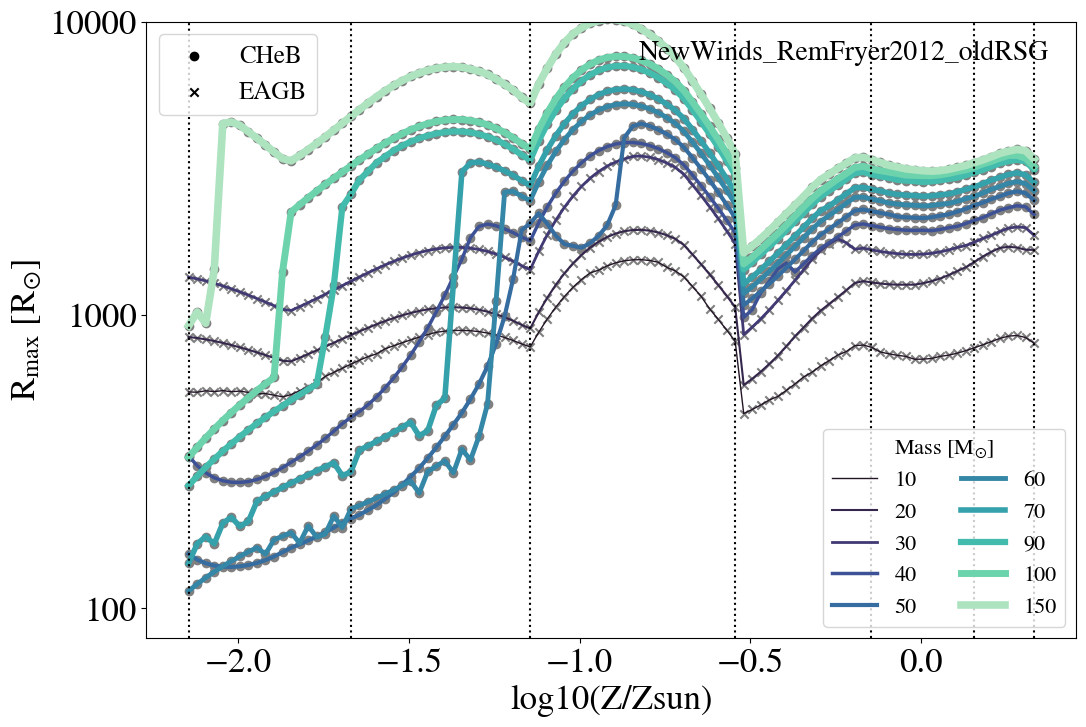

In [13]:
colors =  sns.color_palette("mako", len(data['M0'])) # color for masses

###
# Create a colormap for the stellar types and a normalization
unique_type_values = np.unique(data['maxR_type'][:]) # Get unique stellar types at R max
print('unique_type_values', unique_type_values)
newcmp = ListedColormap(['#a8a8a8', '#707070'])
# newcmp = ListedColormap(sns.color_palette("rainbow", len(unique_type_values))) 


linestyles = ['-'] #['-', '--', '-.', ':']
marker_dict = {4: 'o', 5: 'x'}  # to indicate the type

fig, ax = plt.subplots(figsize =(12,8))

# Plot the data
for mi, mass in enumerate(data['M0']):
    print(mass)
    # Different marker for different stellar type
    marker = marker_dict.get(data['maxR_type'][mi][0], 'o')  # Default to 'o' if the type is not in the dictionary
    im = plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxRadii'][mi]), marker = marker, c = 'grey')
    
    plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxRadii'][mi]), c = colors[mi], lw = 1 + 0.5*mi, label = mass, linestyle = linestyles[mi % len(linestyles)])

first_legend  = plt.legend(title = 'Mass [M$_{\odot}$]', fontsize = 16, title_fontsize = 16, ncol = 2, loc = 'lower right')

# Add vertical lines at the Hurley run grid
Hurley_Z = np.array([0.0001, 0.0003, 0.001, 0.004, 0.01, 0.02, 0.03])
ax.vlines(np.log10(Hurley_Z/0.014), 1.9, 4, colors = 'k', linestyles = 'dotted')

# Write the variation name
ax.text(0.75, 0.95, sim_name, fontsize =20, transform=ax.transAxes, ha = 'center', va = 'center')

# Add the first legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Make little legend for the markers
marker_legends = []
for key in marker_dict:
    marker_legends.append(plt.scatter([], [], c='k', marker=marker_dict[key], label=f"{Stellar_Type_table['types'][key]}"))
plt.legend(handles=marker_legends, loc='upper left')

plt.xlabel('log10(Z/Zsun)')
# Set the y-ticks and their labels
plt.yticks([1, 2, 3, 4.], ['10','100', '1000', '10000'])
plt.ylim(1.9, 4.)
plt.ylabel('R$_{\mathrm{max} }$ [R$_{\odot}$]')
plt.savefig(f'{root_out_dir}/plots/MaxRadius_perZ.pdf',bbox_inches='tight')

plt.show()

# Plot the HR diagram per mass for every metallicity

10


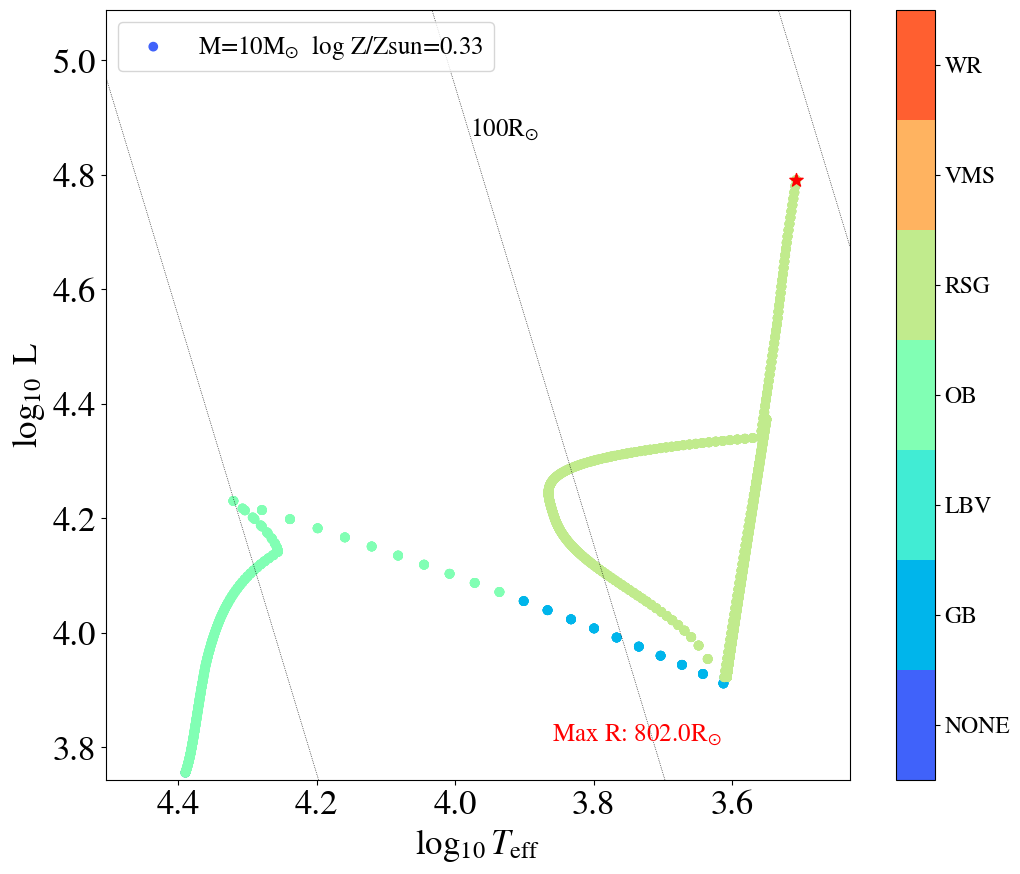

20


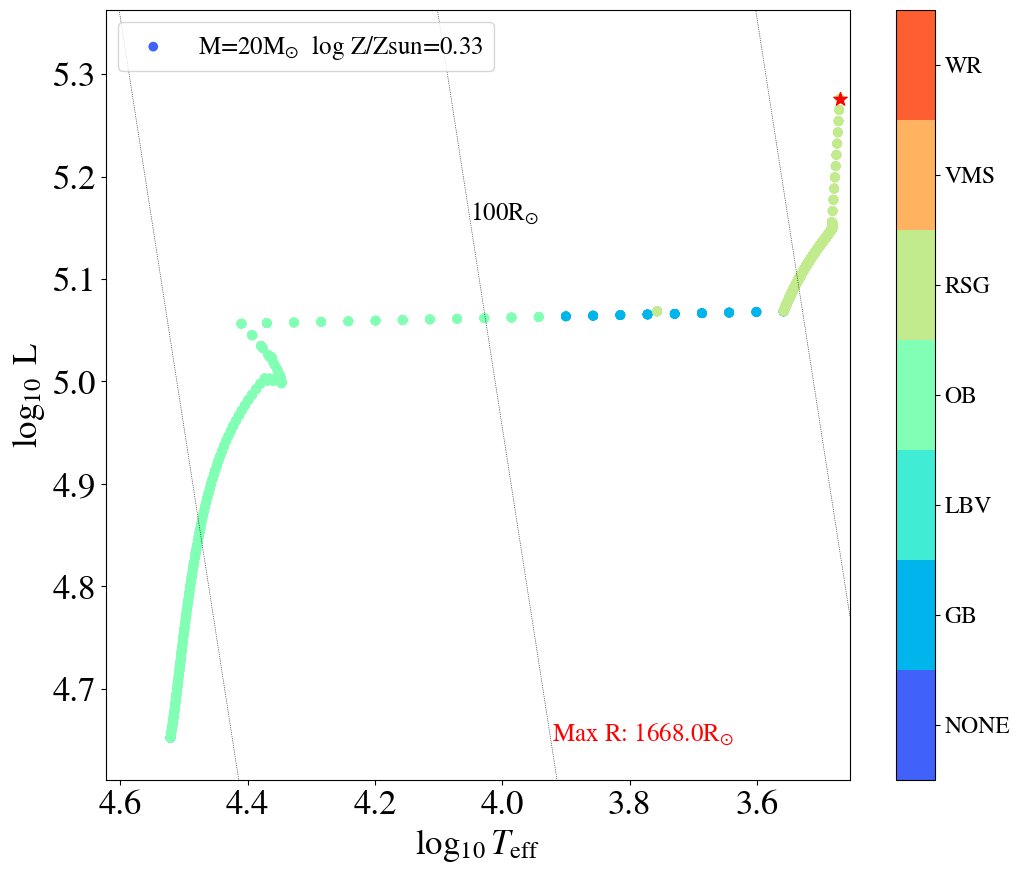

30


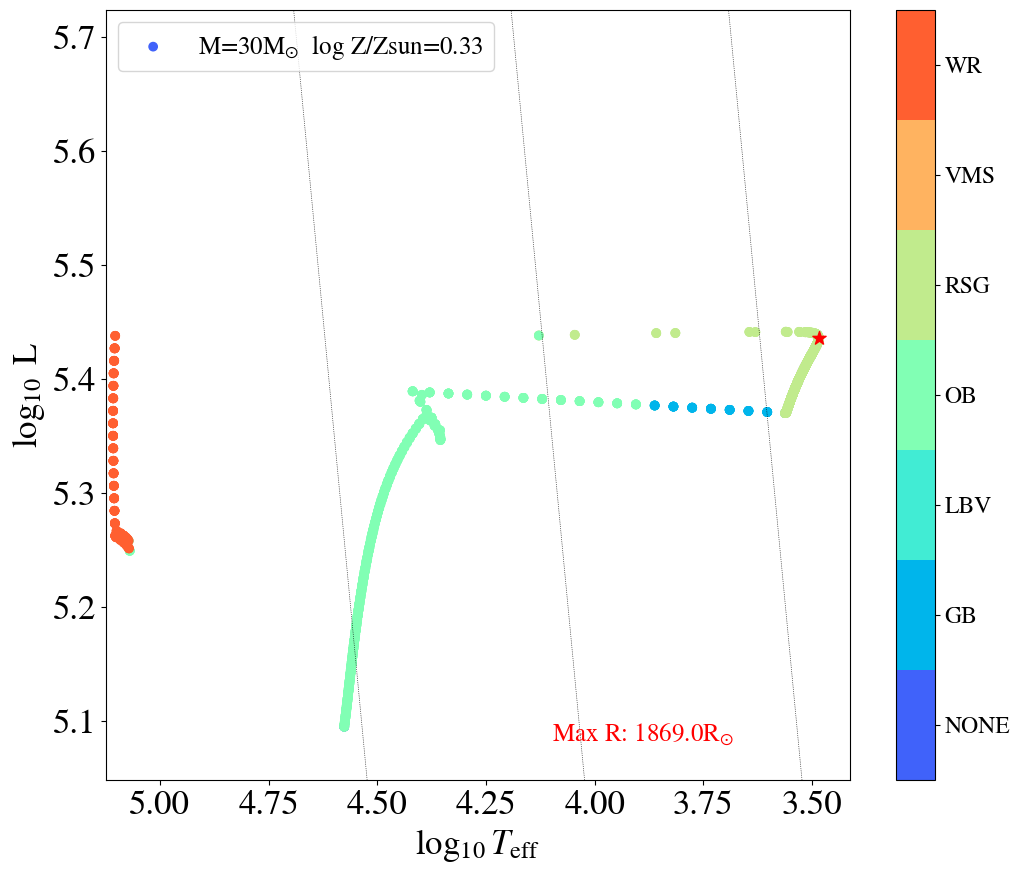

40


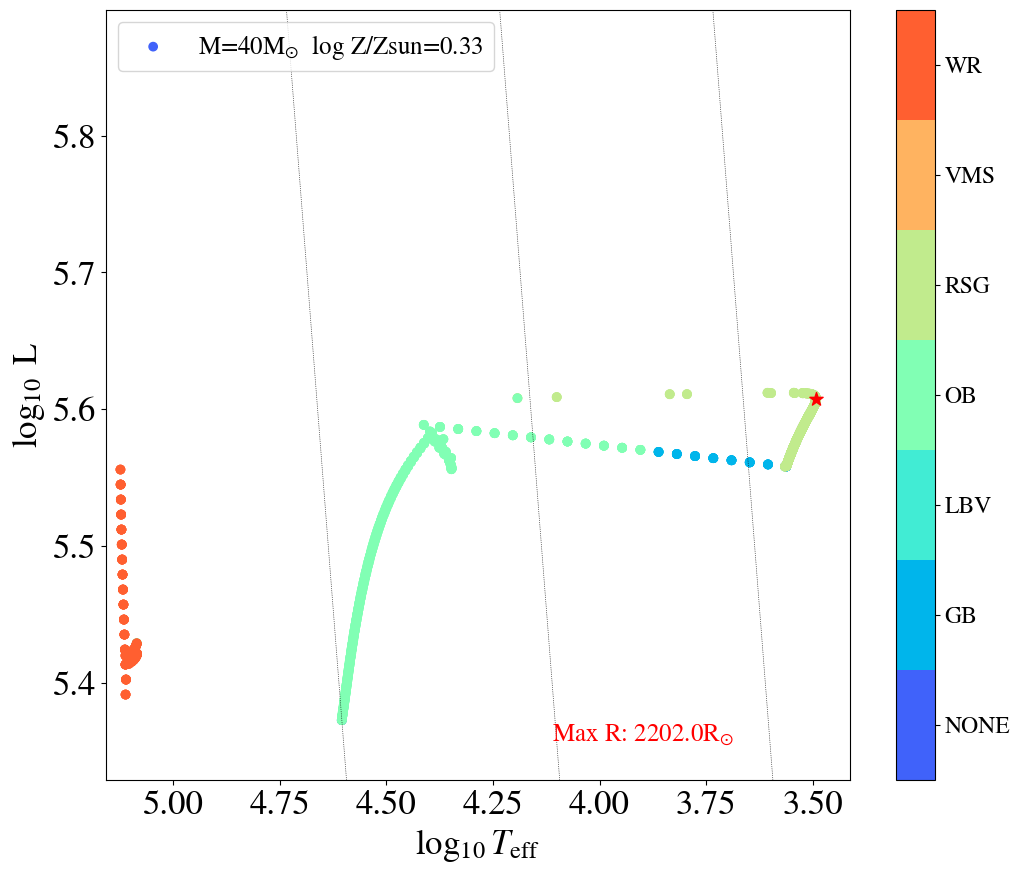

50


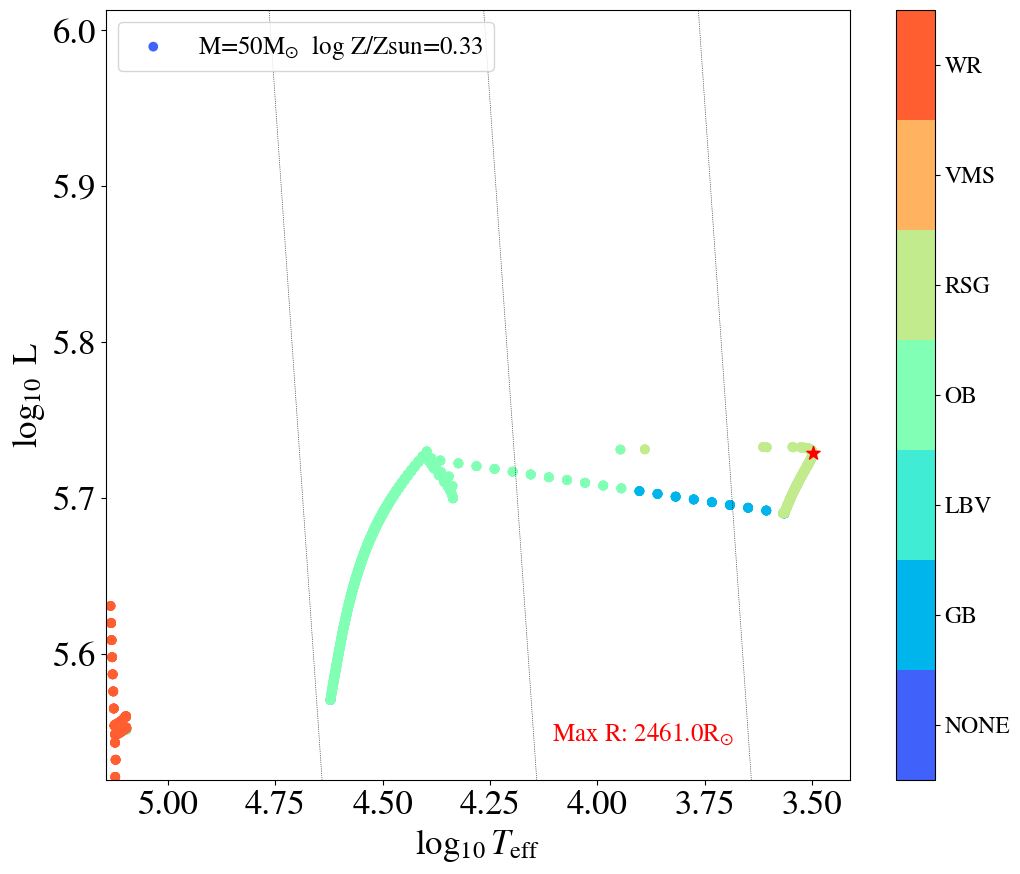

60


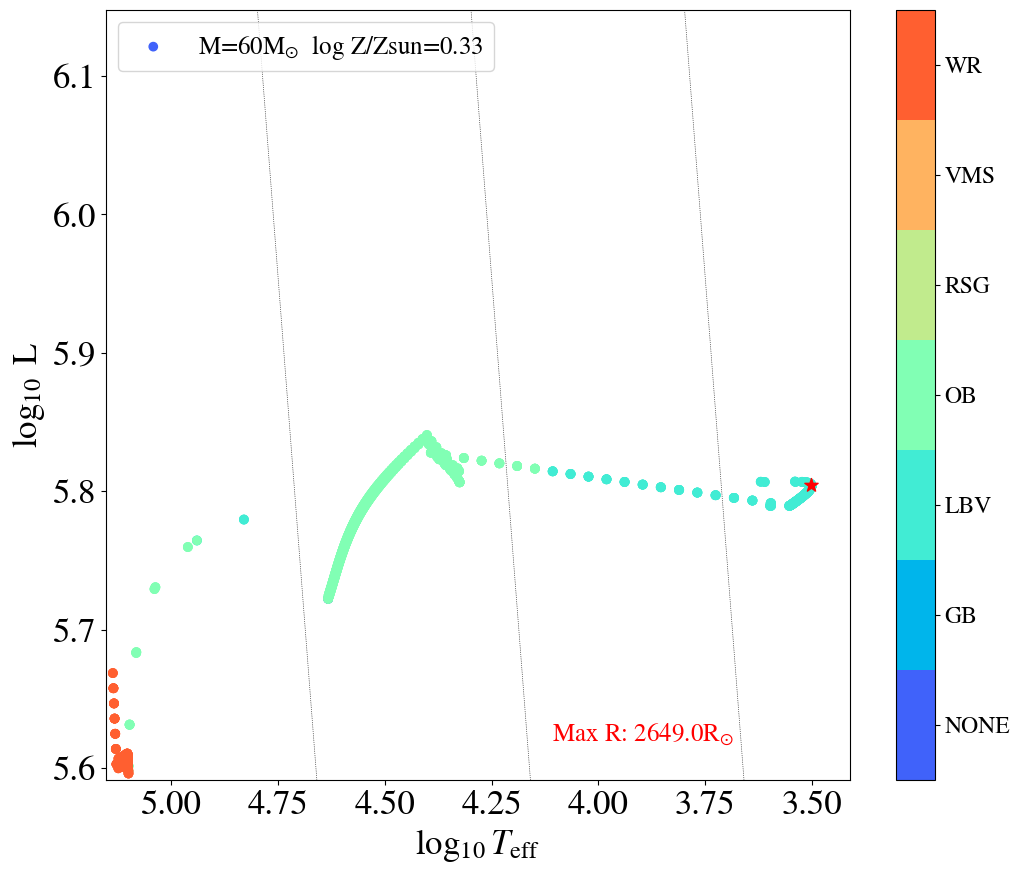

70


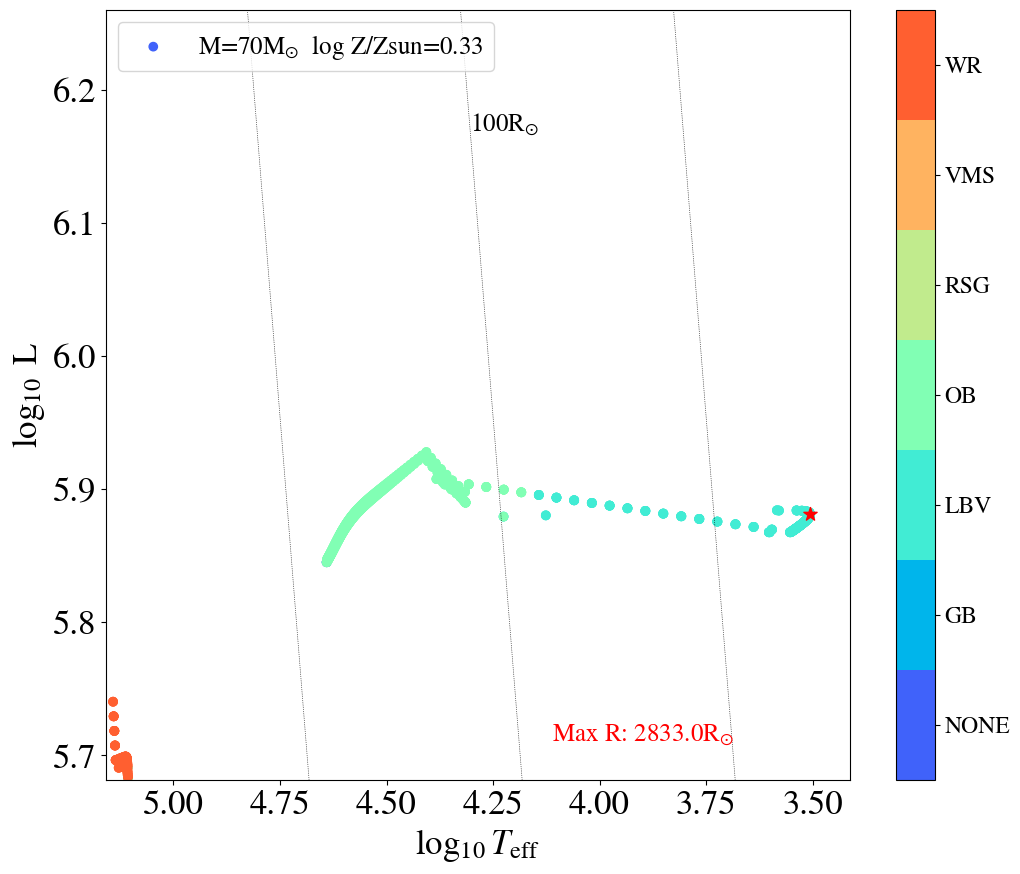

90


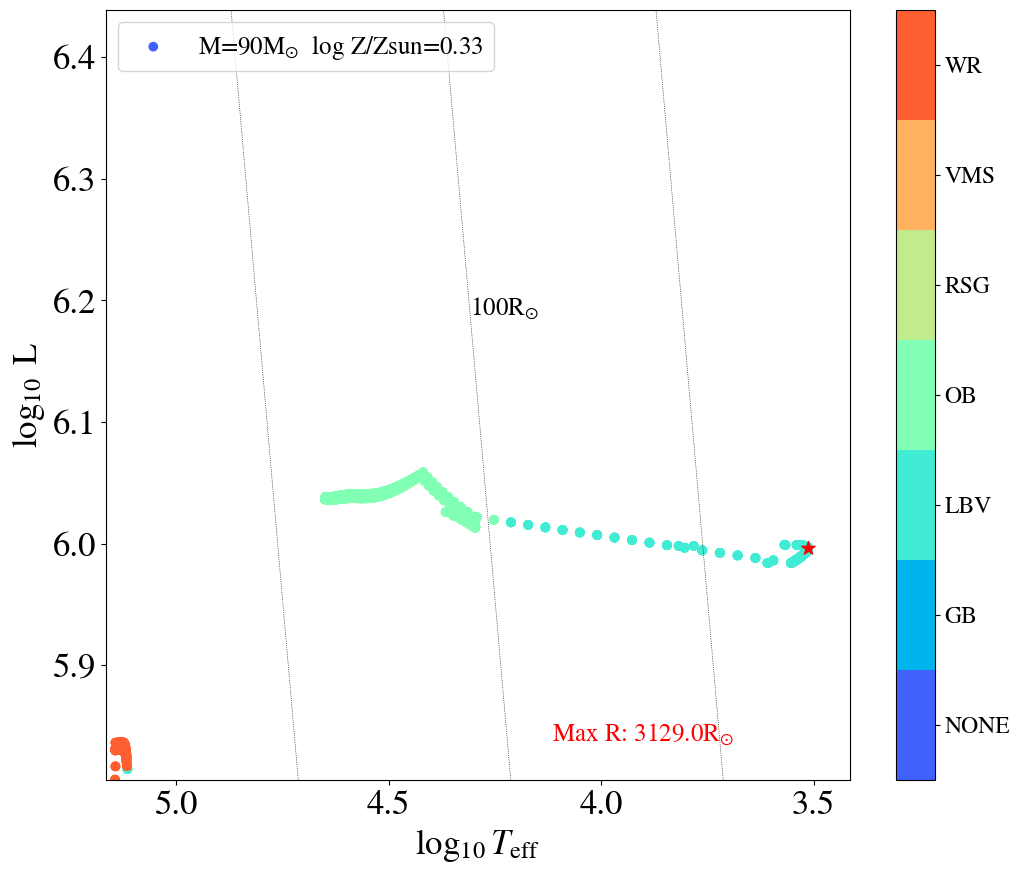

100


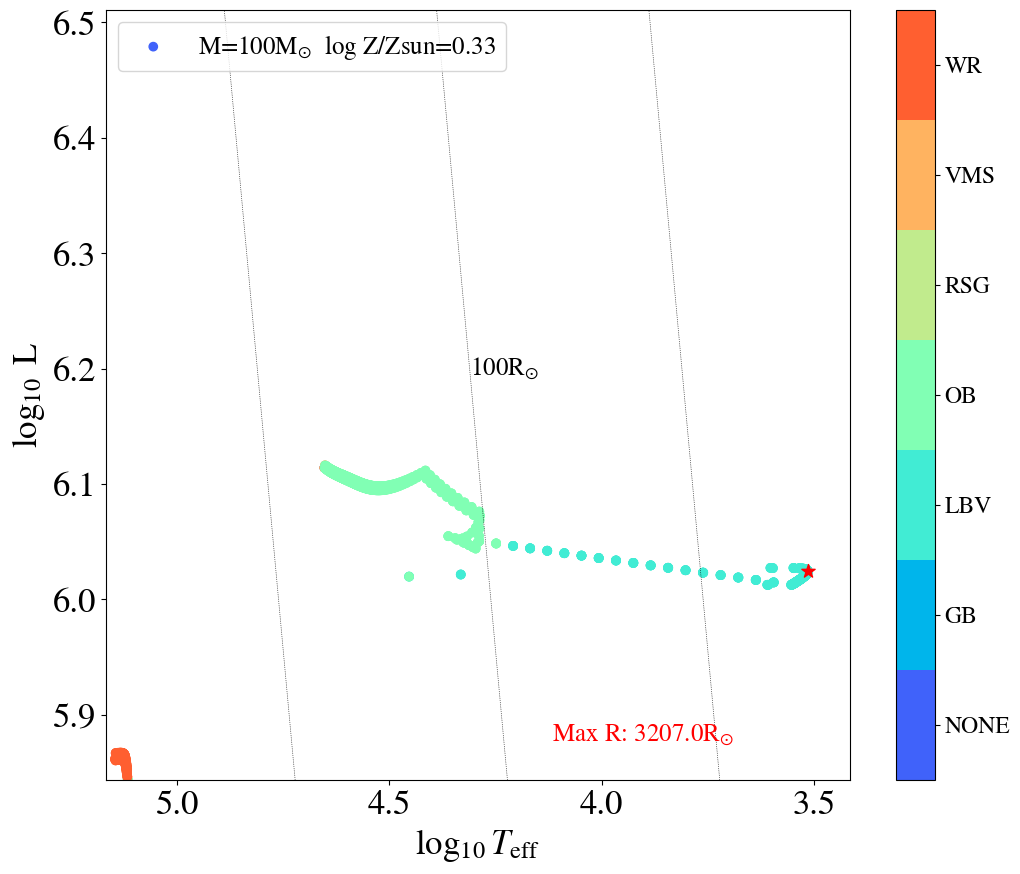

150


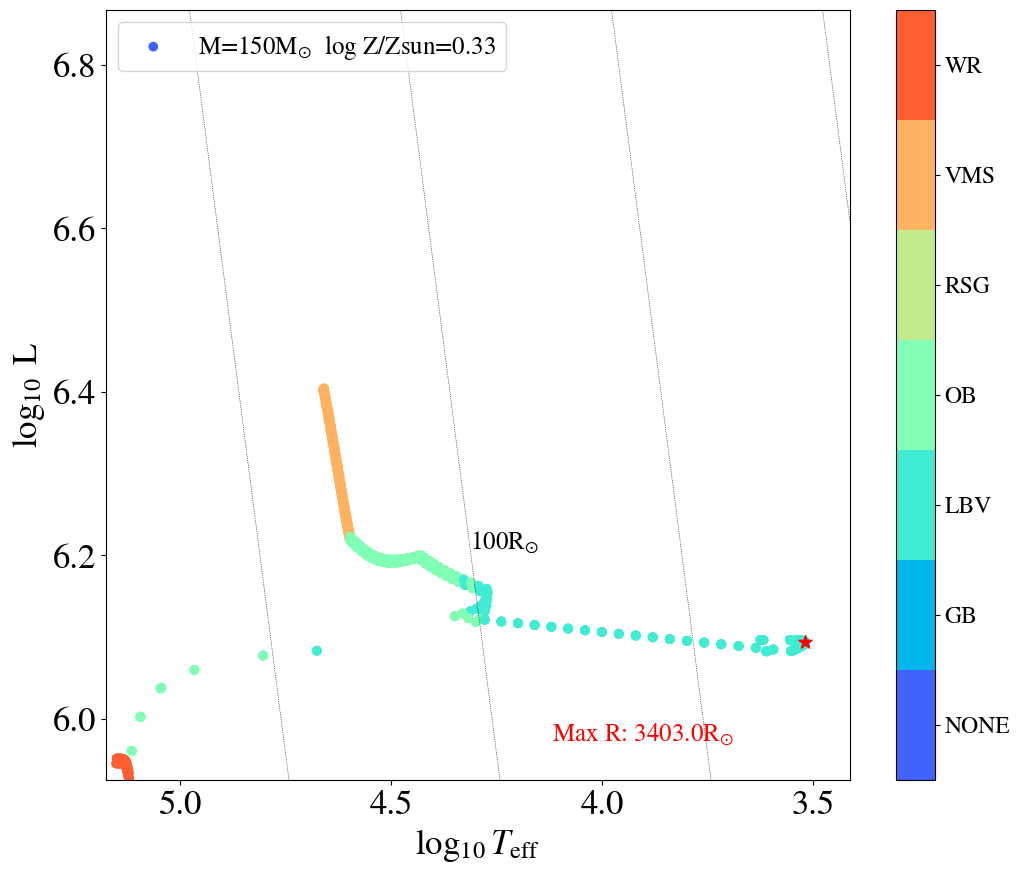

In [14]:
import matplotlib.animation as animation

def L_SB(Teff, R):
    """
    Luminosity at const R using Stefan-Boltzmann law
    Assuming Teff comes in K and R in R_sun
    """
    radius = R*u.Rsun
    L = 4 * np.pi * (radius.to(u.m))**2 * const.sigma_sb * (Teff*u.K)**4
    return L.to(u.Lsun).value

############################################
def Plot_HR_frame(Zi, params):
    """
    Parameters:
    -----------
    Zi          = index of the metallicity
    mi          = mass index
    xmin xmax   = min and max xlim of plot
    ymin ymax   = min and max ylim of plot
    color_key   = what to color you HR diagram by, choose from 'Stellar_Type' or 'Dominant_Wind'
    """
    # parameters for the plot
    mi = params['mi']
    xmin      = params['xmin']
    xmax      = params['xmax']
    ymin      = params['ymin']
    ymax      = params['ymax']
    color_key = params['color_key'] #Stellar_Type/  # choose what to use for the color

    plt.clf()  # Clear the current figure

    # These are the tables that map your numbers to names in the color, they both have a 'types' and 'indices' key
    if color_key == 'Stellar_Type':
        col_map_table = Stellar_Type_table
    if color_key == 'Dominant_Wind':
        col_map_table = Wind_prescr_table

    # Make cmap for stellar types
    newcmp = ListedColormap(sns.color_palette("rainbow", len(col_map_table))) 

    # exclude BH and NS from HR diagram
    mask = data['Stellar_Type'][mi][Zi][()] < 13
    im = plt.scatter(np.log10(data['Teff'][mi][Zi][mask]), np.log10(data['Luminosity'][mi][Zi][mask]), 
                     label=f'M={mass}'+'M$_{\odot}$ '+f' log Z/Zsun={np.round(np.log10(data["Metals"][mi][Zi]/0.014),2) }',
                     c = data[color_key][mi][Zi][mask], cmap = newcmp, 
                     vmin = min(col_map_table['indices']) -0.5, vmax= max(col_map_table['indices']) + 0.5)
    
    # Create the colorbar
    cb = plt.colorbar(im, ticks=col_map_table['indices'])
    cb.ax.set_yticklabels(col_map_table['types'], size = 17)

    # indicate the max radius
    i_maxR = np.argmax(data['Radius'][mi][Zi][mask])
    plt.scatter(np.log10(data['Teff'][mi][Zi][i_maxR]), np.log10(data['Luminosity'][mi][Zi][i_maxR]), 
                marker = '*', s = 100, c = 'r')
    plt.text(0.6, 0.05 , f"Max R: {np.round(data['Radius'][mi][Zi][i_maxR],0)}" + "R$_{\odot}$", 
             transform=plt.gca().transAxes, fontsize=18, color = 'r') 

    #PLot lines of constant radii
    Effective_temps = np.logspace(xmin, xmax)
    for R in [10, 100, 1000, 10000]:
        Lum = np.log10(L_SB(Effective_temps, R))
        plt.plot(np.log10(Effective_temps), Lum,label = None, ls = ':', lw = 0.5, c = 'k' )
        # Annotate R values
        halfway = int(len(Effective_temps)/2)
        plt.text(np.log10(Effective_temps[halfway]), Lum[halfway], f'{R}' +'R$_{\odot}$', fontsize = 18, clip_on=True )
        

    # Plot settings
    plt.xlabel('$\log_{10} T_{\mathrm{eff} }$')
    plt.ylabel('$\log_{10}$ L')
    plt.xlim(xmin, xmax )
    # Invert the x axis
    plt.gca().invert_xaxis()
    plt.ylim(ymin, ymax)
    plt.legend(loc = 'upper left', fontsize = 18)
    return im,


############################################
color_by = 'Dominant_Wind' #Stellar_Type

# loop over the masses
for mi, mass in enumerate(data['M0']):
    print(mass)

    ########
    fig, ax = plt.subplots(figsize=(12,10))

    # Ugly but it works
    Min_logTeff, Max_logTeff, Min_logL, Max_logL = [], [], [], []
    for Zi in range(100):
        mask = data['Stellar_Type'][mi][Zi][()] < 13 # Exclude BH and NS
        Min_logTeff.append(min(np.log10(data['Teff'][mi][Zi][mask])) )
        Max_logTeff.append(max(np.log10(data['Teff'][mi][Zi][mask])) )
        Min_logL.append(min(np.log10(data['Luminosity'][mi][Zi][mask])) )
        Max_logL.append(max(np.log10(data['Luminosity'][mi][Zi][mask])) )


    # Create the animation
    params = {'mi': mi, 'xmin': min(Min_logTeff), 'xmax': max(Max_logTeff), 'ymin': min(Min_logL), 'ymax': max(Max_logL), 'color_key': color_by } # the params to pass to the HR function
    ani = animation.FuncAnimation(fig, Plot_HR_frame, fargs=(params,), frames=range(100), blit=True)

    ani.save(f'{root_out_dir}/plots/HR_M{mass}_{color_by}.gif', writer='pillow', fps=15)

    plt.show()



10


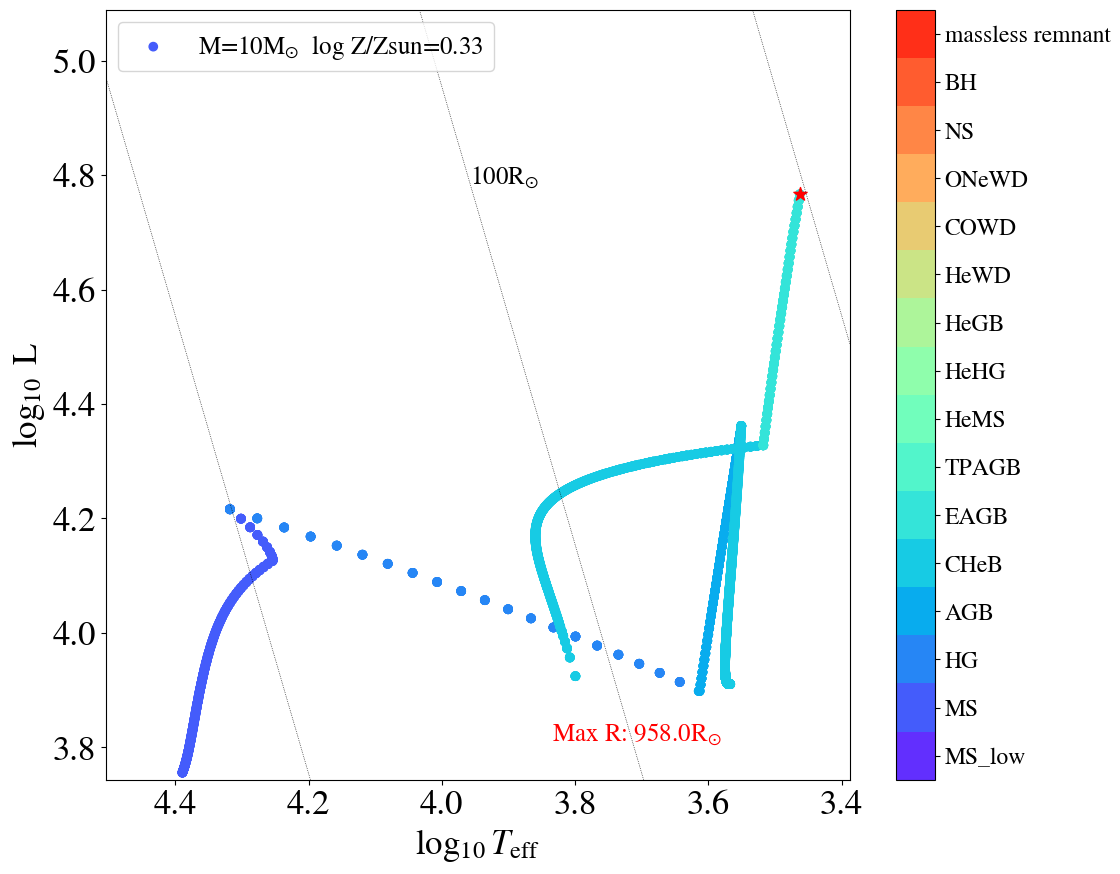

20


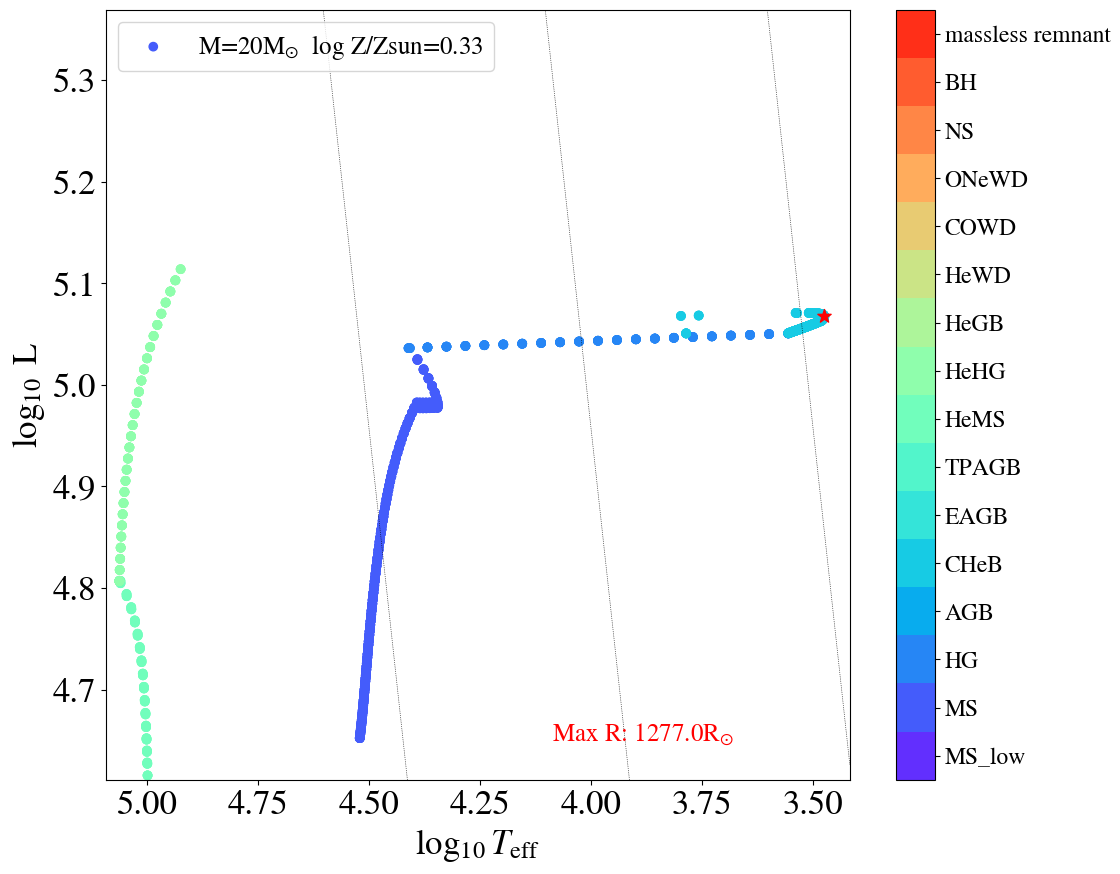

30


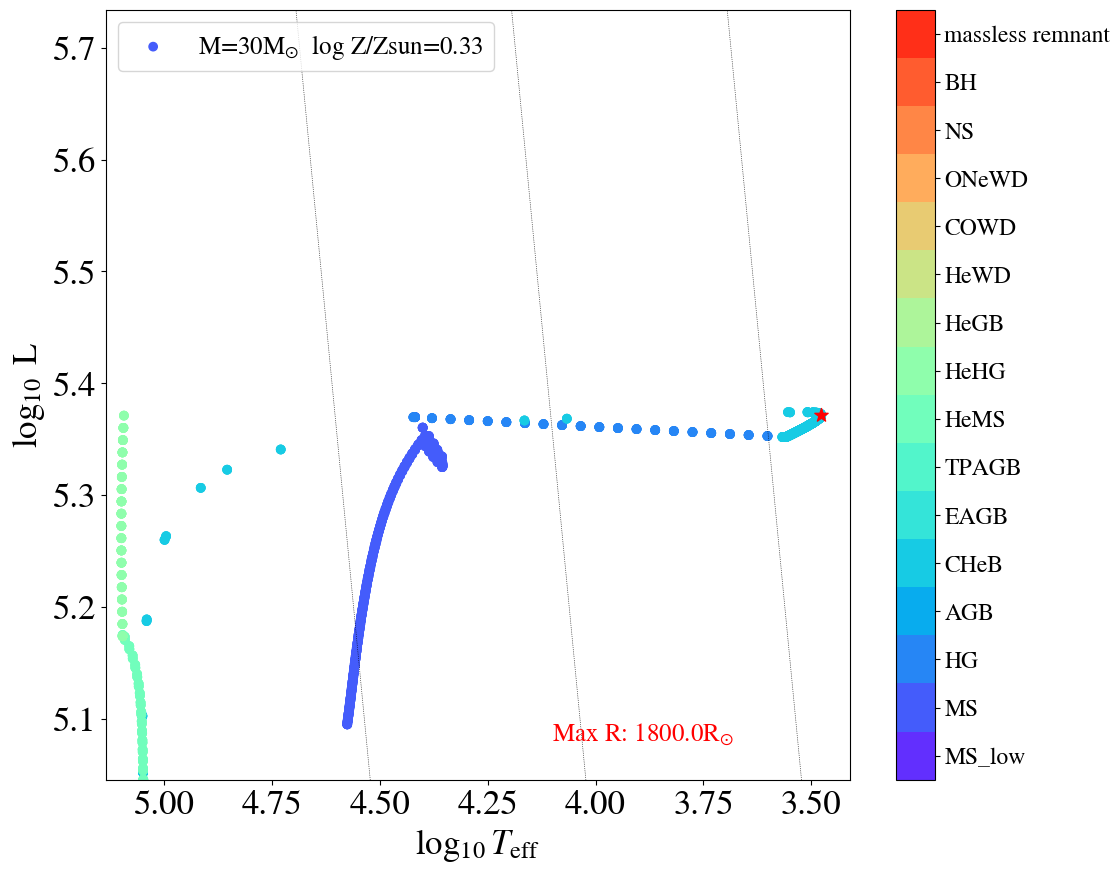

40


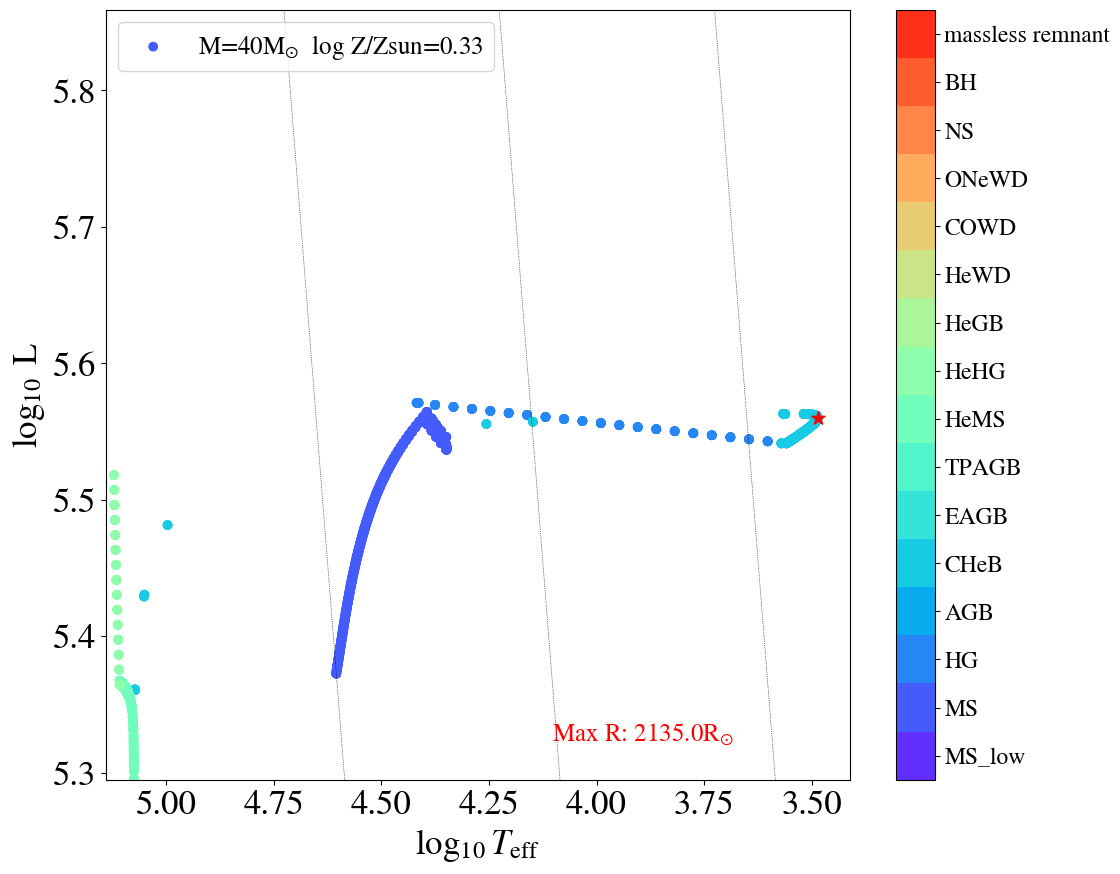

50


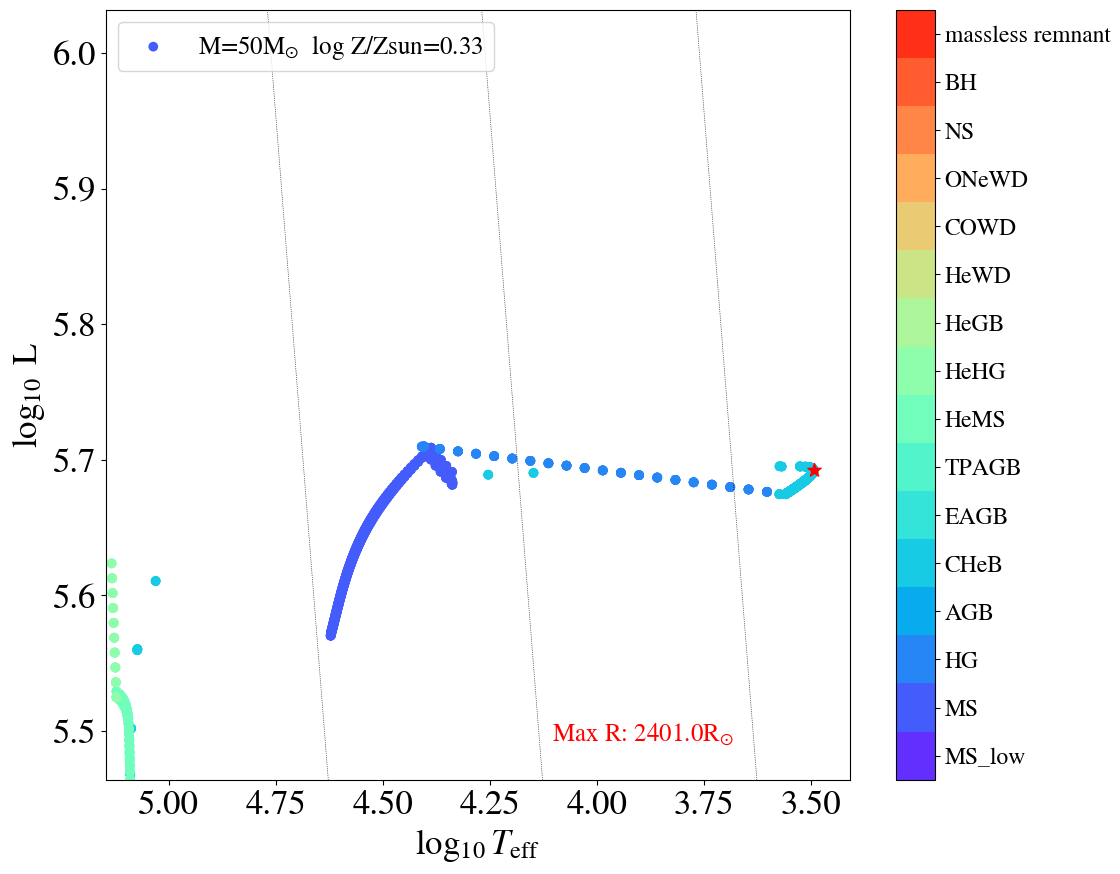

60


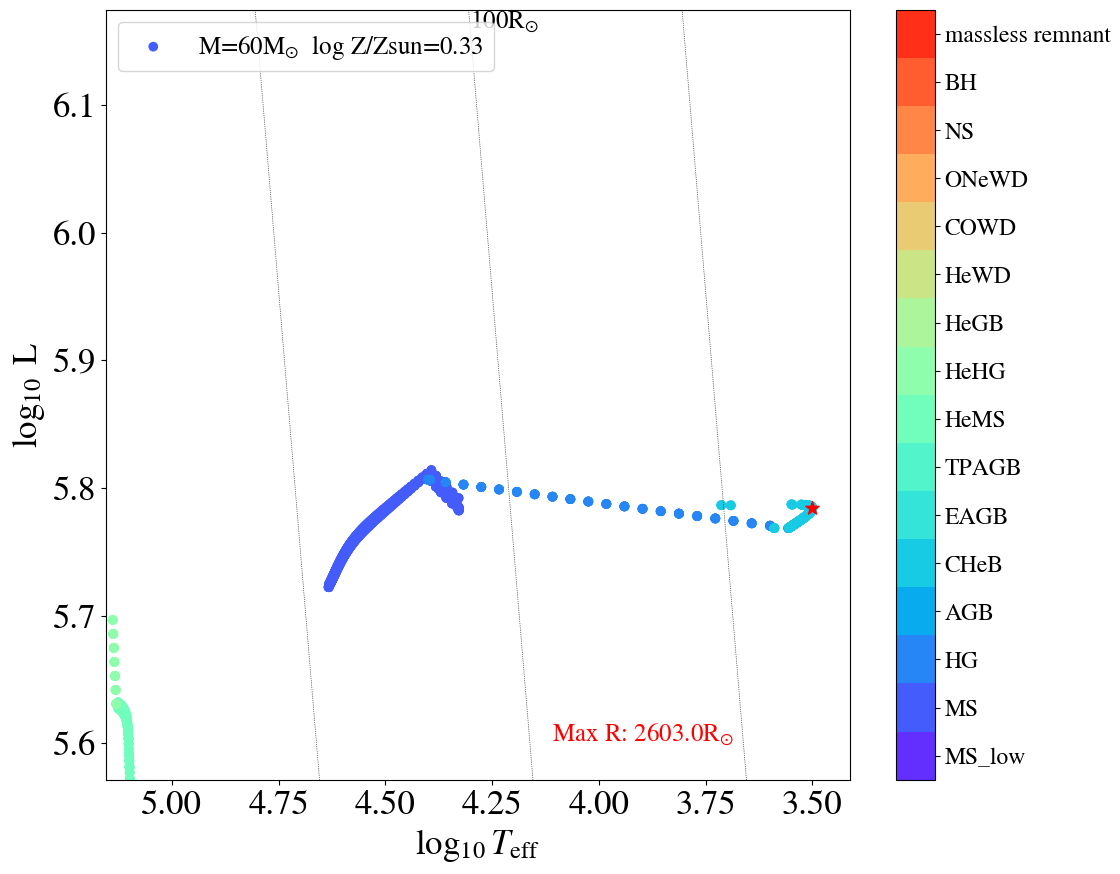

70


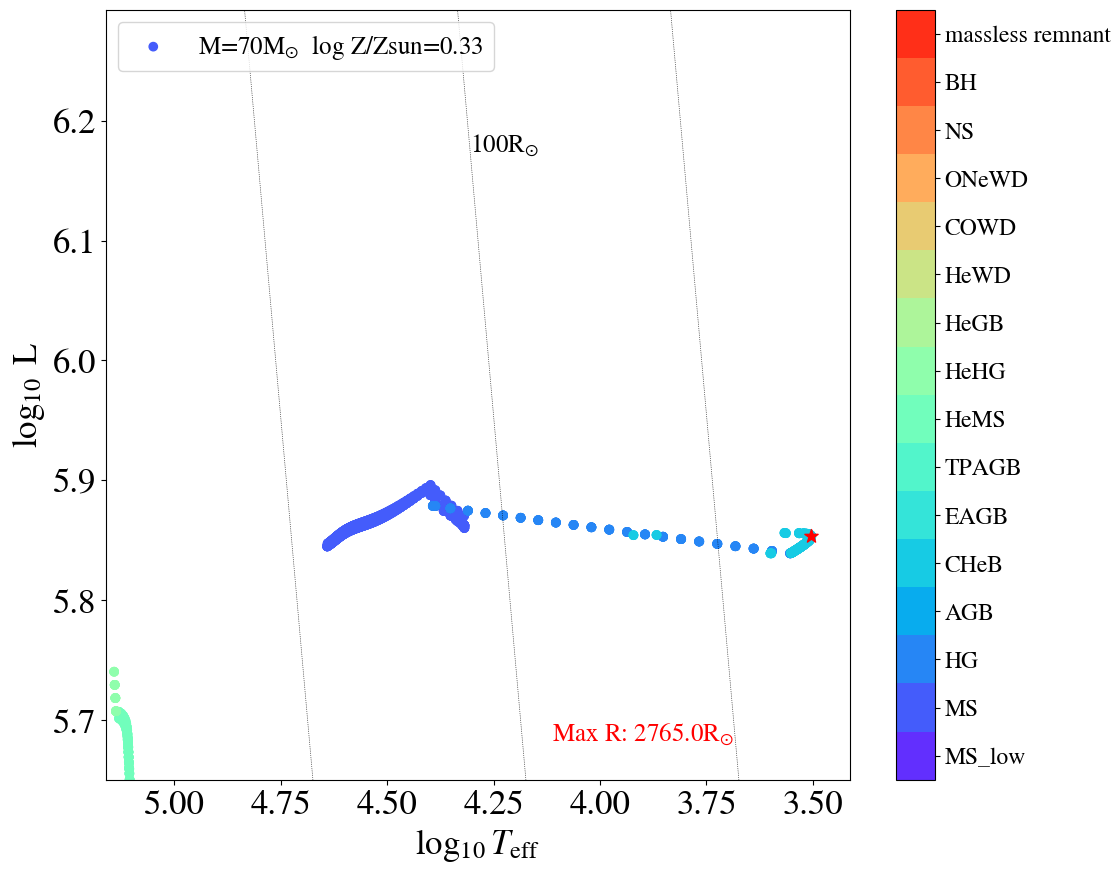

90


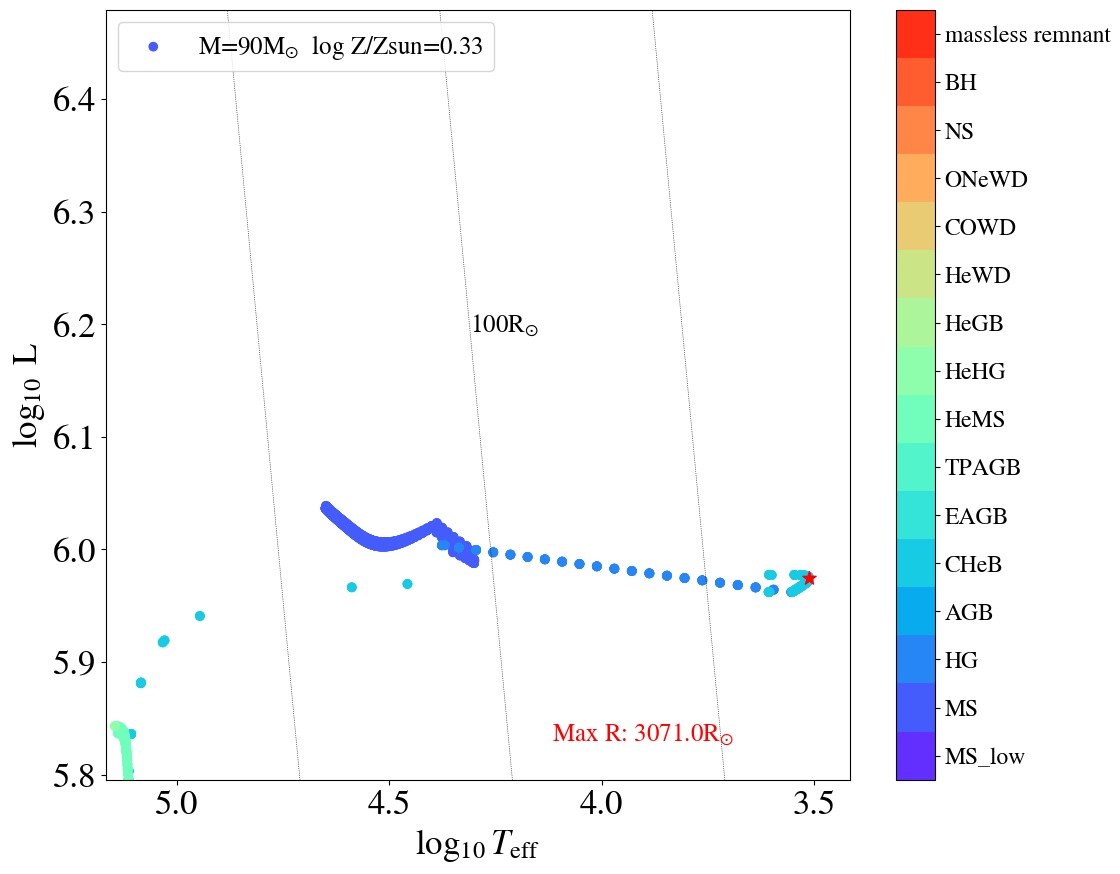

100


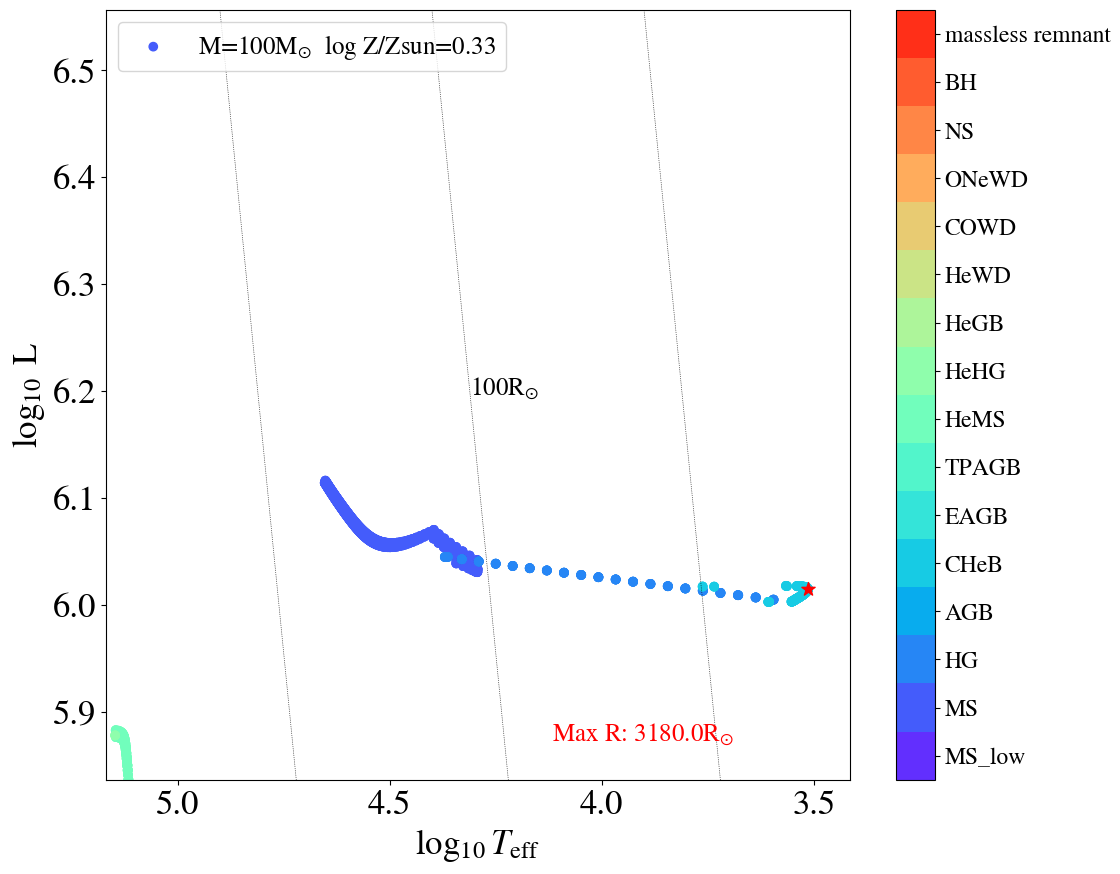

150


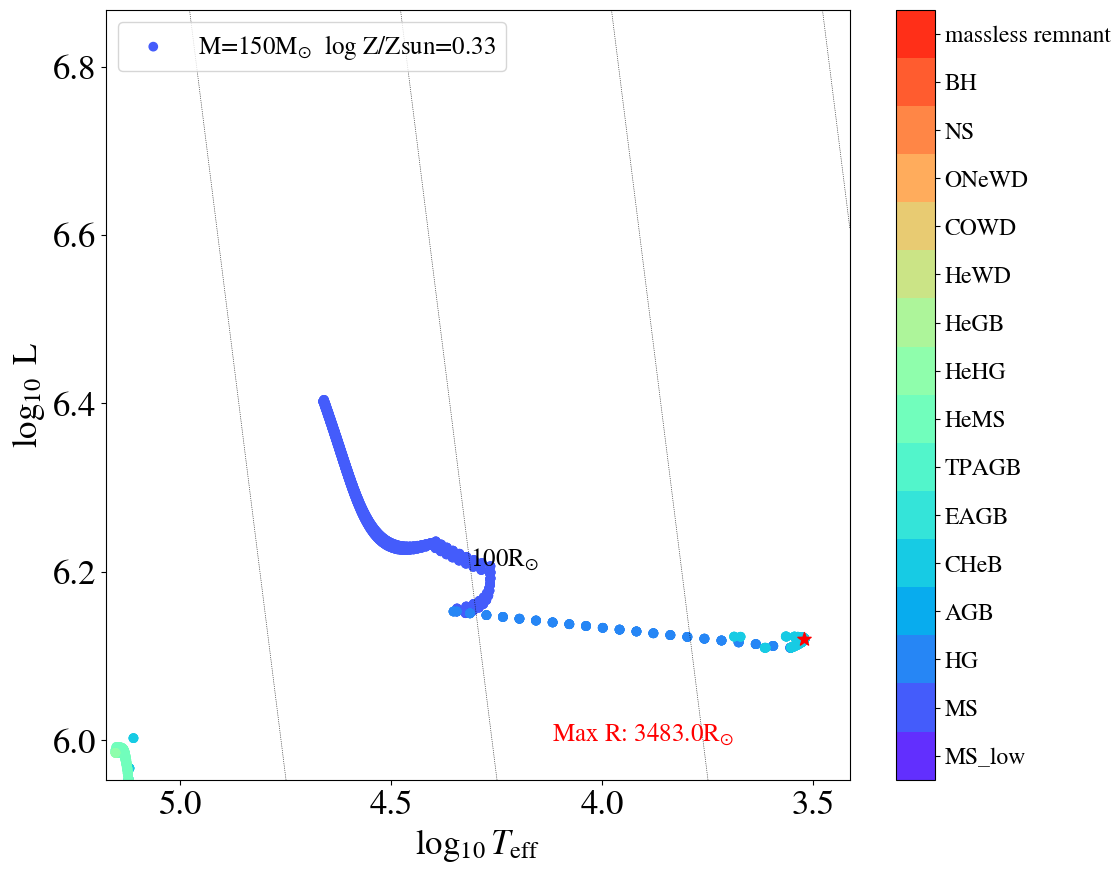

In [25]:
import matplotlib.animation as animation

def L_SB(Teff, R):
    """
    Luminosity at const R using Stefan-Boltzmann law
    Assuming Teff comes in K and R in R_sun
    """
    radius = R*u.Rsun
    L = 4 * np.pi * (radius.to(u.m))**2 * const.sigma_sb * (Teff*u.K)**4
    return L.to(u.Lsun).value

############################################
def Plot_HR_frame(Zi, params):
    # parameters for the plot
    mi = params['mi']
    xmin = params['xmin']
    xmax = params['xmax']
    ymin = params['ymin']
    ymax = params['ymax']

    plt.clf()  # Clear the current figure

    # exclude BH and NS from HR diagram
    mask = data['Stellar_Type'][mi][Zi][()] < 13
    im = plt.scatter(np.log10(data['Teff'][mi][Zi][mask]), np.log10(data['Luminosity'][mi][Zi][mask]), 
                     label=f'M={mass}'+'M$_{\odot}$ '+f' log Z/Zsun={np.round(np.log10(data["Metals"][mi][Zi]/0.014),2) }',
                     c = data['Stellar_Type'][mi][Zi][mask], cmap = newcmp, 
                     vmin = min(Stellar_Type_table['indices']) -0.5, vmax= max(Stellar_Type_table['indices']) + 0.5)
    
    # Create the colorbar
    cb = plt.colorbar(im, ticks=Stellar_Type_table['indices'])
    cb.ax.set_yticklabels(Stellar_Type_table['types'], size = 17)

    # indicate the max radius
    i_maxR = np.argmax(data['Radius'][mi][Zi][mask])
    plt.scatter(np.log10(data['Teff'][mi][Zi][i_maxR]), np.log10(data['Luminosity'][mi][Zi][i_maxR]), 
                marker = '*', s = 100, c = 'r')
    plt.text(0.6, 0.05 , f"Max R: {np.round(data['Radius'][mi][Zi][i_maxR],0)}" + "R$_{\odot}$", 
             transform=plt.gca().transAxes, fontsize=18, color = 'r') 

    #PLot lines of constant radii
    Effective_temps = np.logspace(xmin, xmax)
    for R in [10, 100, 1000, 10000]:
        Lum = np.log10(L_SB(Effective_temps, R))
        plt.plot(np.log10(Effective_temps), Lum,label = None, ls = ':', lw = 0.5, c = 'k' )
        # Annotate R values
        halfway = int(len(Effective_temps)/2)
        plt.text(np.log10(Effective_temps[halfway]), Lum[halfway], f'{R}' +'R$_{\odot}$', fontsize = 18, clip_on=True )
        

    # Plot settings
    plt.xlabel('$\log_{10} T_{\mathrm{eff} }$')
    plt.ylabel('$\log_{10}$ L')
    plt.xlim(xmin, xmax )
    # Invert the x axis
    plt.gca().invert_xaxis()
    plt.ylim(ymin, ymax)
    plt.legend(loc = 'upper left', fontsize = 18)
    return im,


############################################
# Make cmap for stellar types
newcmp = ListedColormap(sns.color_palette("rainbow", len(Stellar_Type_table))) 


# loop over the masses
for mi, mass in enumerate(data['M0']):
    print(mass)

    ########
    fig, ax = plt.subplots(figsize=(12,10))

    # Ugly but it works
    Min_logTeff, Max_logTeff, Min_logL, Max_logL = [], [], [], []
    for Zi in range(100):
        mask = data['Stellar_Type'][mi][Zi][()] < 13 # Exclude BH and NS
        Min_logTeff.append(min(np.log10(data['Teff'][mi][Zi][mask])) )
        Max_logTeff.append(max(np.log10(data['Teff'][mi][Zi][mask])) )
        Min_logL.append(min(np.log10(data['Luminosity'][mi][Zi][mask])) )
        Max_logL.append(max(np.log10(data['Luminosity'][mi][Zi][mask])) )


    # Create the animation
    params = {'mi': mi, 'xmin': min(Min_logTeff), 'xmax': max(Max_logTeff), 'ymin': min(Min_logL), 'ymax': max(Max_logL) }
    ani = animation.FuncAnimation(fig, Plot_HR_frame, fargs=(params,), frames=range(100), blit=True)

    ani.save(f'{root_out_dir}/plots/HR_M{mass}.gif', writer='pillow', fps=15)

    plt.show()



# for Zi in range(100):
#     mask = data['Stellar_Type'][mi][Zi][()] < 13
#     im = plt.scatter(data['Teff'][mi][Zi][mask], data['Luminosity'][mi][Zi][mask], label=f'M={mass} Z={data["Metals"][mi][Zi]}',
#                 c = data['Stellar_Type'][mi][Zi][mask], cmap = newcmp,
#                 vmin = min(Stellar_Type_table['indices']) -0.5, vmax= max(Stellar_Type_table['indices']) + 0.5)


# OLD STUFF (to be removed)

In [ ]:
# compile task line to run
# task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; 


In [ ]:
###############################################
def replaceFileLine(file_dir, line_num, replacestr):
    """
    file_dir   = The file of which you would like to change a line
    line_num   = The line number that you want to change
    replacestr = The string that you want to replace this line wtth
    """
    #Open file of interest
    with open (file_dir, "r") as myfile:
        data = myfile.readlines()
    #Replace line
    data[line_num-1] = replacestr
    # Write everything back
    with open (file_dir, "w") as wfile:
        wfile.writelines(data)

#################################################################
##   Job script
#################################################################
# module load gsl boost hdf5 gcc python 
# If you get a libraries: libhdf5 error, just go into loc + '/MainRun/' and run python runSubmit.py
# cp /mnt/home/lvanson/Winds2/code/COMPAS_Output_Definitions.txt $run_dir/

import subprocess

# Define the job script
def job_script(M, dataloc, var_name, grid_file_name, container_name):
    return f"""#!/bin/bash
#SBATCH --job-name=COMPAS_det                 #job name
#SBATCH --nodes=1                           # Number of nodes
#SBATCH --ntasks=1                          # Number of cores
#SBATCH --output=comp{M}.out                     # output storage file
#SBATCH --error=comp{M}.err                      # error storage file
#SBATCH --time=0-00:10:00                   # Runtime format: D-HH:MM:SS
#SBATCH --mem=1G                           # use 1 GB of Memory per cpu 
#SBATCH -p genx                              # genx is partition for small serial jobs
#SBATCH --mail-type=FAIL                    # Only if failed

#Load modules
module load gsl boost hdf5 gcc python

echo $COMPAS_ROOT_DIR/src/COMPAS --version

export run_dir={dataloc}/{var_name}/SingleStarGrids

# Make a dir to store the single star grids is necessary
mkdir -p $run_dir

# And an extra dir for the slurm output
mkdir -p $run_dir/slurm_output/

# Copy the output definitions
cp /mnt/home/lvanson/Winds2/code/GridSubmitCOMPAS/masterfolder/MainRun/COMPAS_Output_Definitions.txt $run_dir/

#CD to the root directory
cd $run_dir/

# Run your job
$COMPAS_ROOT_DIR/src/COMPAS --grid '{dataloc}/{var_name}/{grid_file_name}' --output-container '{container_name}' --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt'  > $run_dir/slurm_output/{M}_output.txt

"""
# --mass-loss-prescription 'BELCZYNSKI2010'
# --cool-wind-mass-loss-multiplier # noCoolWindN1e6 = 0, StrongCoolWindN1e6 = 10.0
# --wolf-rayet-multiplier # noWRWindN1e6 = 0, StrongWRWindN1e6 = 5.0
# --overall-wind-mass-loss-multiplier # ZEROWindsN1e6
# --black-hole-kicks (I think this secretly kills all kicks) options: [FULL, REDUCED, ZERO, FALLBACK], default = FALLBACK  # noBHkickN1e6
# --luminous-blue-variable-prescription # noLBVN1e6 (options: [NONE, HURLEY_ADD, HURLEY, BELCZYNSKI], default = HURLEY_ADD)
# --add-options-to-sysparms (options: [ALWAYS, GRID, NEVER], default = GRID)

## !!!! To retrieve the 'old' winds in v02_46_01  !!!!  ##
# --wolf-rayet-multiplier 0.1 --mass-loss-prescription BELCZYNSKI2010

#################################################################
##   Write a grid file to use
#################################################################
for M in [10,20,30,40,50,60,70,80,90,100,150]:
    print('mass', M)
    
    grid_file_name = f'Single_star_M{M}_metallicities.txt'
    container_name = f'SingleStars_M{M}{var_name}'

    old_wind_flags = '--wolf-rayet-multiplier 0.1 --mass-loss-prescription BELCZYNSKI2010'
    #################################################################
    # Write the grid
    if write_gird:
        # Open the output file for writing
        with open(dataloc + var_name + '/' + grid_file_name, 'w') as f:
            # Write a grid file of len mass_array
            for i in range(len(Z_array)):
                # write the line
                f.write(f'--random-seed {i} --initial-mass-1 {M} --initial-mass-2 {M} --metallicity {Z_array[i]} --semi-major-axis {sma} \n ' )
    
    #################################################################
    # Run the Job
    if run_grid:
        Jobscript = job_script(M, dataloc, var_name, grid_file_name, container_name) # Write the job script to a file
        with open(dataloc + var_name + f'/singlestargrid{M}.sh', 'w') as f:
            f.write(Jobscript)

        print(dataloc + var_name  + f'/singlestargrid{M}.sh')
        # Run the job script
        process = subprocess.Popen(['sbatch', dataloc + var_name  + f'/singlestargrid{M}.sh'])
        # process = subprocess.Popen(['sbatch', dataloc + var_name  + f'/singlestargrid{M}.sh'])
        print(f"Job submitted with process ID: {process.pid}")


    # Run the job script
    # Jobscript = job_script(dataloc, M)
    # completed_process = subprocess.run(Jobscript, shell=True, capture_output=True, text=True)

    # # The output of the command is in completed_process.stdout
    # print(completed_process.stdout)

mass 10
mass 20
mass 30
mass 40
mass 50
mass 60
mass 70
mass 80
mass 90
mass 100
mass 150


In [ ]:
    # # change the grid file that is being used
    # replaceFileLine(dataloc + "/MainRun/compasConfig.yaml",208, f"   --grid: '{dataloc}/{grid_file_name}' " + "\n")
    # # change the output container
    # replaceFileLine(dataloc + "/MainRun/compasConfig.yaml",212, f"   --output-container: '../{container_name}' " + "\n")
    # # Run detailed? 
    # replaceFileLine(dataloc + "/MainRun/compasConfig.yaml",13,   "   --detailed-output: True" + "\n")
    # # Use own logfile
    # replaceFileLine(dataloc + "/MainRun/compasConfig.yaml",262,   "   --logfile-definitions: 'COMPAS_Output_Definitions.txt'" + "\n")
    # # Use old wind defaults
    # replaceFileLine(dataloc + "/MainRun/compasConfig.yaml",262,   "   --mass-loss-prescription: 'BELCZYNSKI2010'" + "\n")
